In [1]:
from torchvision import datasets, transforms, models
import torch.utils.data as data

import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch
from tqdm.notebook import trange, tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),        
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

dataset = datasets.ImageFolder(root=r'..\Dataset\Train', transform=transform)

# 20 : 80
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset =  data.random_split(dataset, [train_size, test_size])

trainloader =  data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader =  data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)



In [3]:
googlenet = models.googlenet(pretrained=True)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = len(dataset.classes)  
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)

for param in googlenet.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)


c:\Users\david\Desktop\Code\DNN\DNNvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\Desktop\Code\DNN\DNNvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def count_parameters(NN):
    return sum([p.numel() for p in NN.parameters() if p.requires_grad==True])

print(f"trainable parameters: {count_parameters(googlenet)}")

trainable parameters: 12300


Train+plot

Epoch 1/100: 0batch [00:00, ?batch/s]

[Epoch 1, Batch 100] loss: 0.139
Accuracy after epoch 1: 95.10%


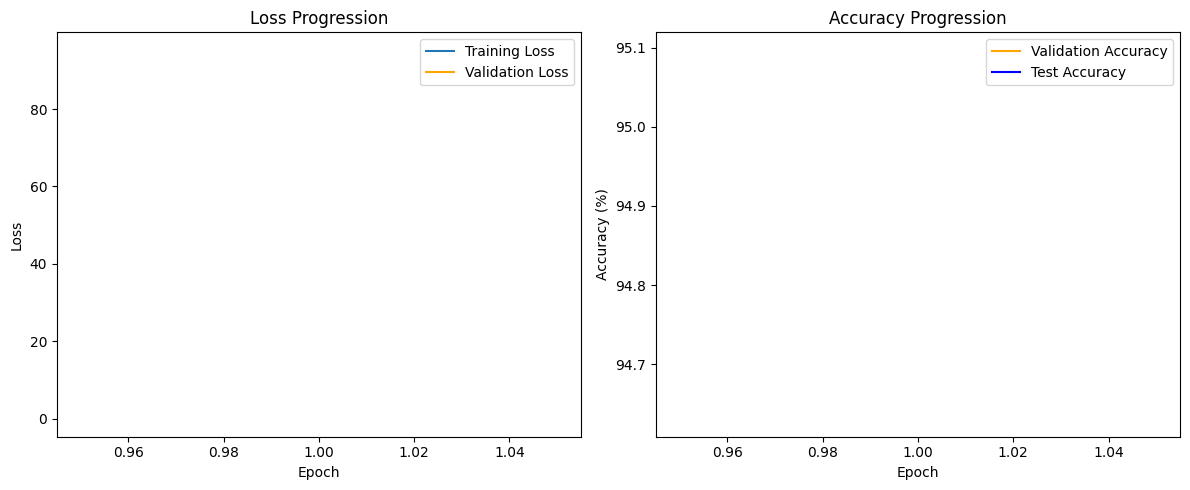

Epoch 2/100: 0batch [00:00, ?batch/s]

[Epoch 2, Batch 100] loss: 0.140
Accuracy after epoch 2: 95.10%


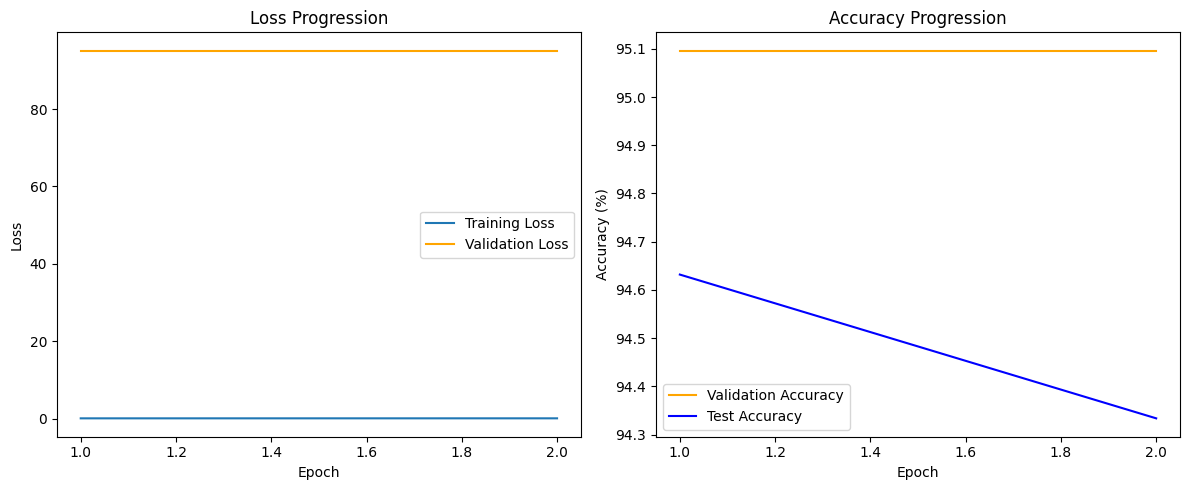

Epoch 3/100: 0batch [00:00, ?batch/s]

[Epoch 3, Batch 100] loss: 0.138
Accuracy after epoch 3: 95.23%


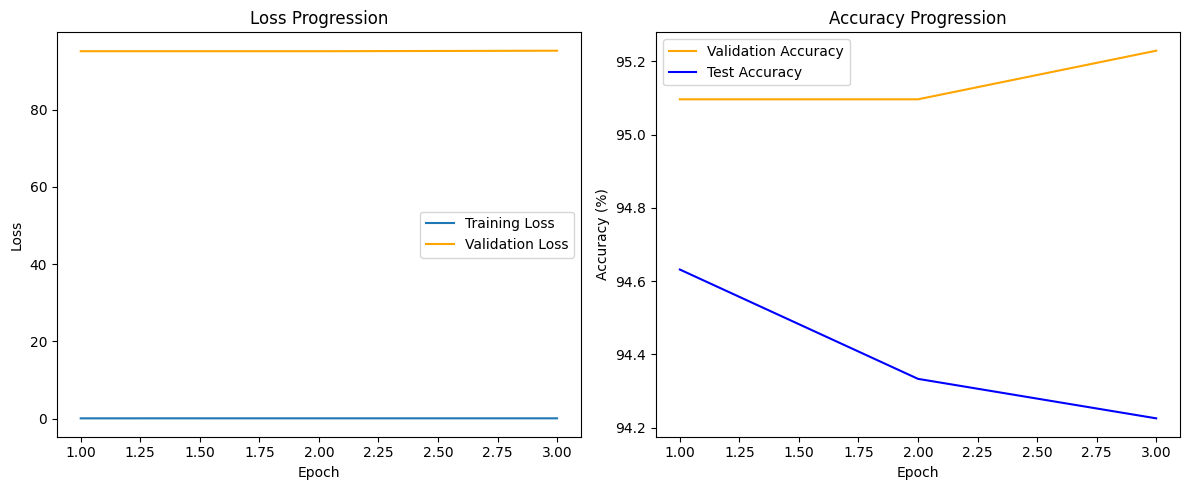

Epoch 4/100: 0batch [00:00, ?batch/s]

KeyboardInterrupt: 

In [23]:
num_epochs = 100  
train_losses = []
val_losses = []  
val_accuracies = []
acc_history = []
for epoch in range(num_epochs):
    googlenet.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(i, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

        if i % 64 == 0:  
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
            
    epoch_accuracy = 100 * correct / total  
    acc_history.append(epoch_accuracy)
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    googlenet.eval()  
    correct = 0
    total = 0
    val_running_loss = 0.0 
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = googlenet(inputs)
            
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = val_running_loss / len(testloader)
    val_losses.append(avg_val_loss)
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f"Accuracy after epoch {epoch + 1}: {100 * correct / total:.2f}%")
    if (epoch+1) % 10 == 0:
        plotGraphs(epoch)

print('Finished Training')



In [22]:
def plotGraphs(num_epochsIn):
    
    epochs = range(1, num_epochsIn + 2)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Loss Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.plot(epochs, acc_history, label='Test Accuracy', color='blue')
    plt.title('Accuracy Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

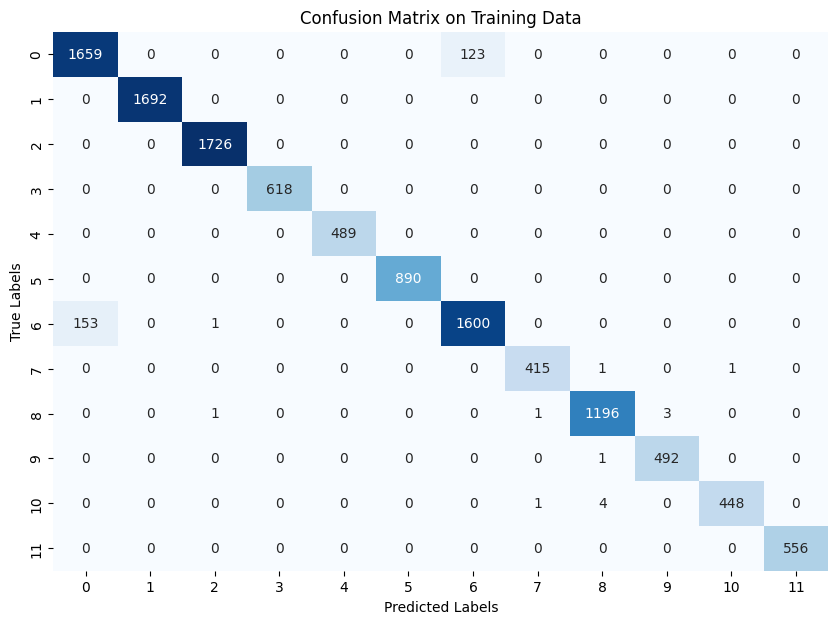

In [24]:
googlenet.eval()  

all_preds = []
all_labels = []

with torch.no_grad():  
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = googlenet(inputs)
        _, predicted = torch.max(outputs, 1)  
        
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix on Training Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

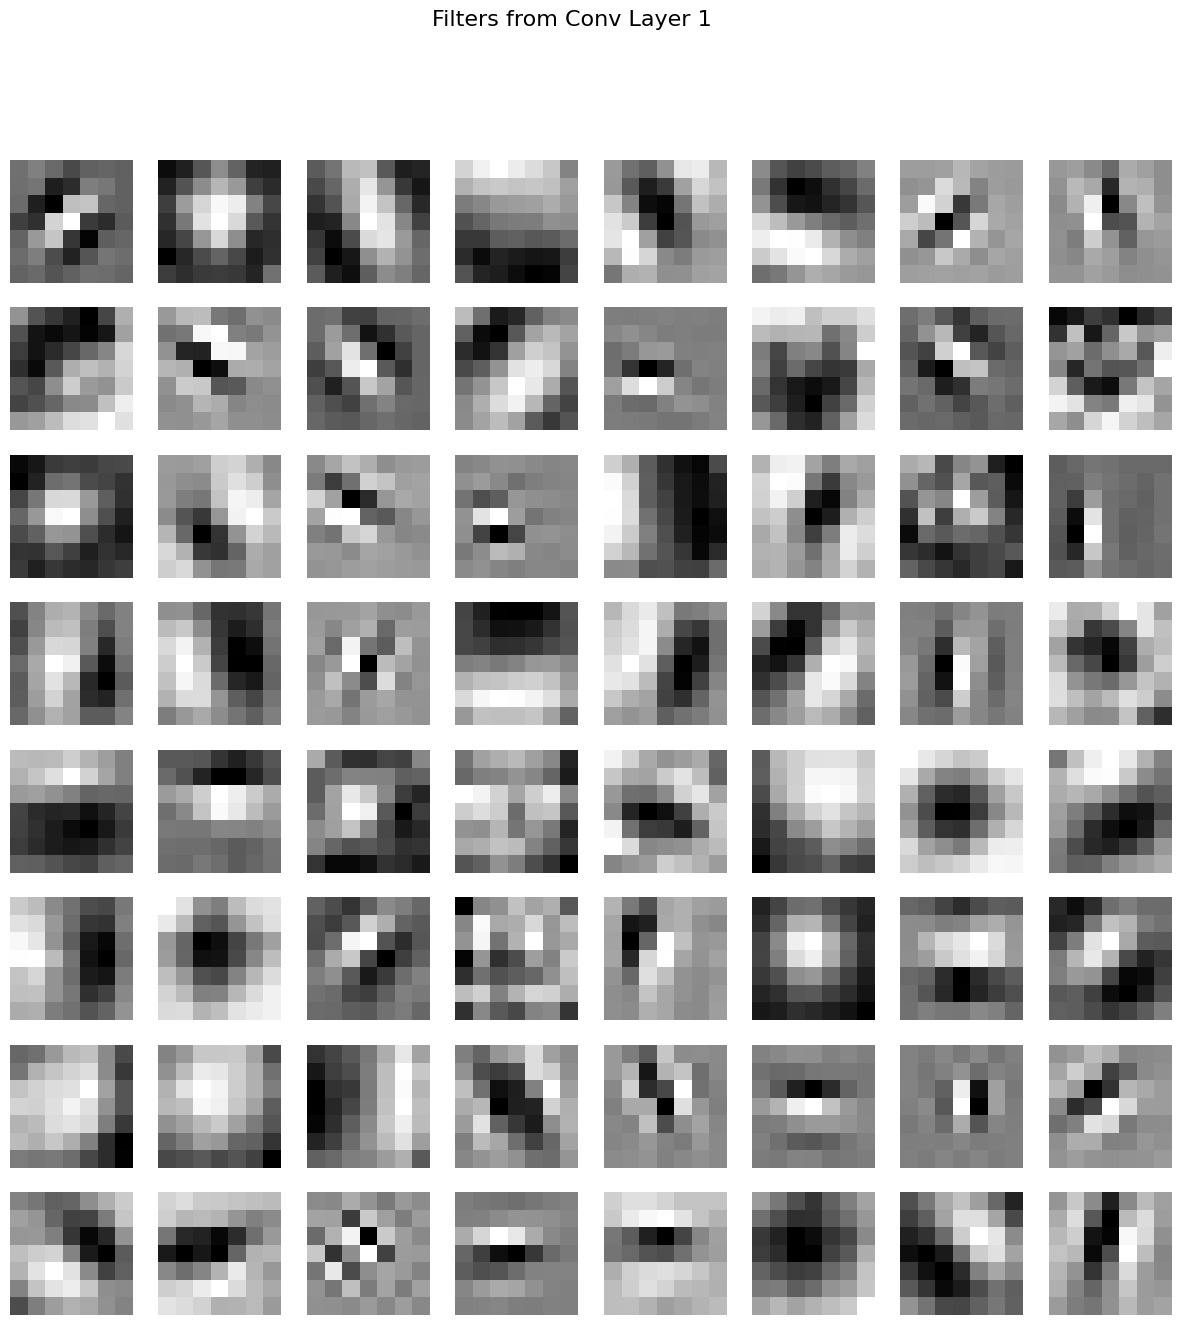

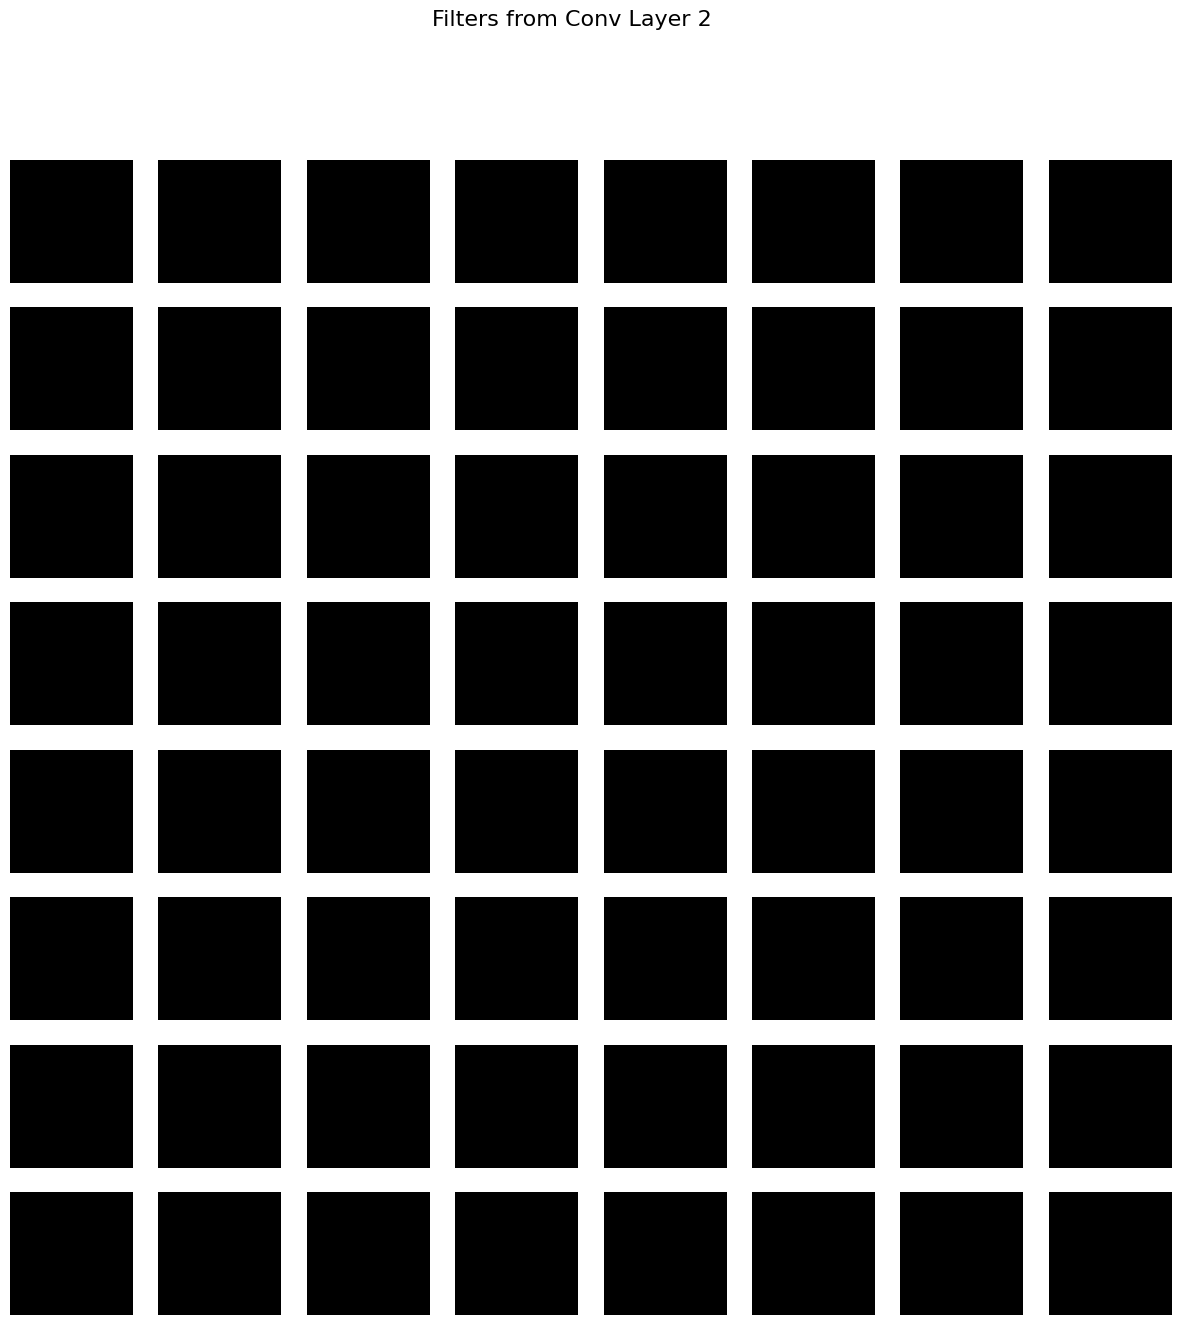

In [10]:
import math
def visualize_filters(model):
    conv_layer_count = 0  
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layer_count += 1

            if conv_layer_count == 1:
                filters = module.weight.data.cpu()
                filters = (filters - filters.min()) / (filters.max() - filters.min())  

                num_filters = filters.shape[0]
                num_cols = 8  
                num_rows = math.ceil(num_filters / num_cols)

                fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

                for i in range(num_filters):
                    row = i // num_cols
                    col = i % num_cols
                    axs[row, col].imshow(filters[i, 0, :, :], cmap='gray')
                    axs[row, col].axis('off')

                for j in range(i + 1, num_rows * num_cols):
                    fig.delaxes(axs[j // num_cols, j % num_cols])

                plt.suptitle("Filters from Conv Layer 1", fontsize=16)
                plt.show()

            if conv_layer_count == 2:
                filters = module.weight.data.cpu()
                filters = (filters - filters.min()) / (filters.max() - filters.min()) 

                num_filters = filters.shape[0]
                num_cols = 8  
                num_rows = math.ceil(num_filters / num_cols)

                fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

                for i in range(num_filters):
                    row = i // num_cols
                    col = i % num_cols
                    axs[row, col].imshow(filters[i, 0, :, :], cmap='gray')
                    axs[row, col].axis('off')

                for j in range(i + 1, num_rows * num_cols):
                    fig.delaxes(axs[j // num_cols, j % num_cols])

                plt.suptitle("Filters from Conv Layer 2", fontsize=16)
                plt.show()
                break  
 

visualize_filters(googlenet)

Feature maps for layer: conv1.conv


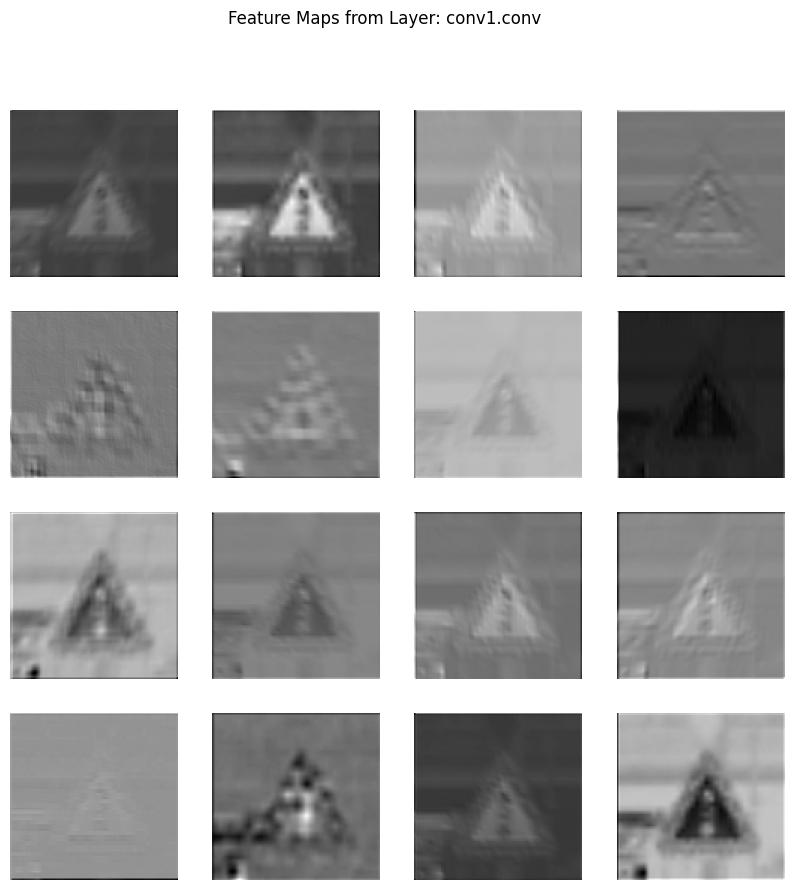

Feature maps for layer: conv2.conv


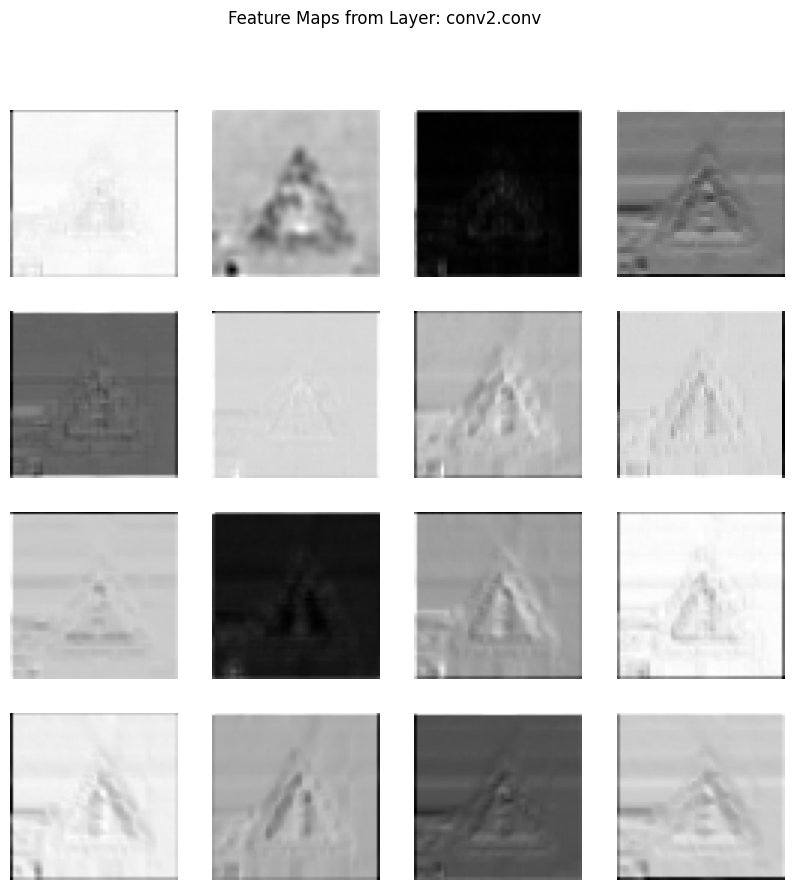

Feature maps for layer: conv3.conv


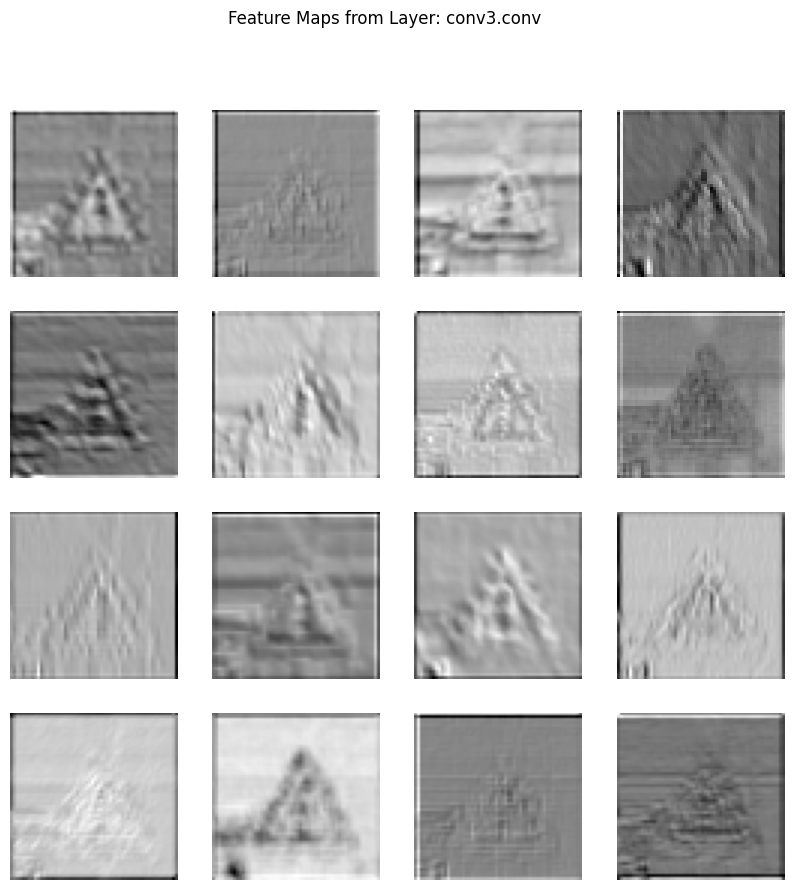

Feature maps for layer: inception3a.branch1.conv


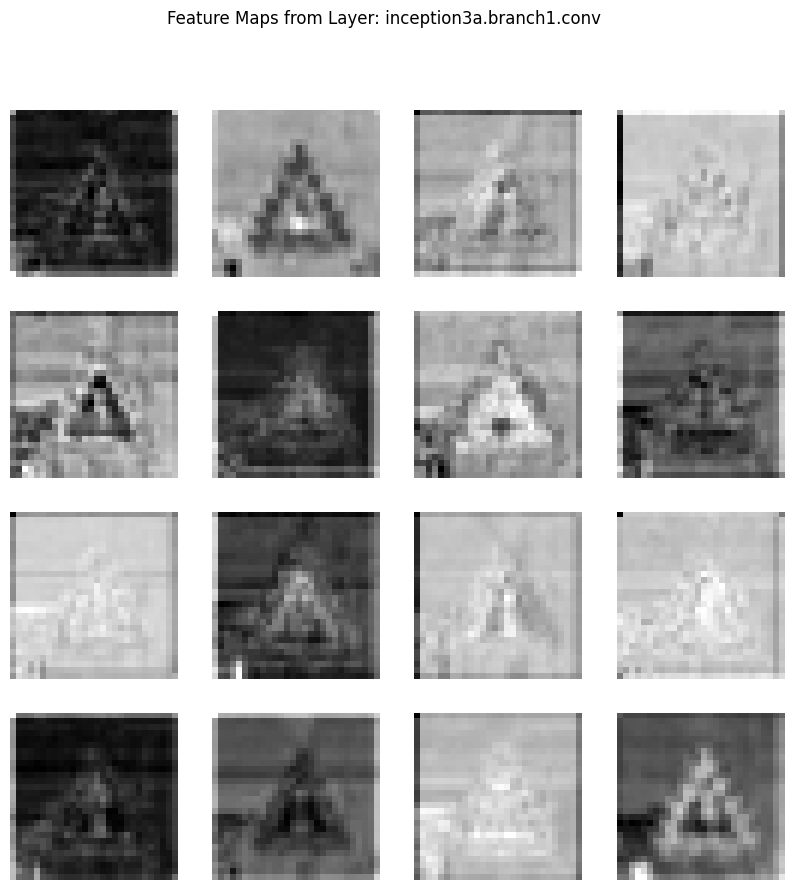

Feature maps for layer: inception3a.branch2.0.conv


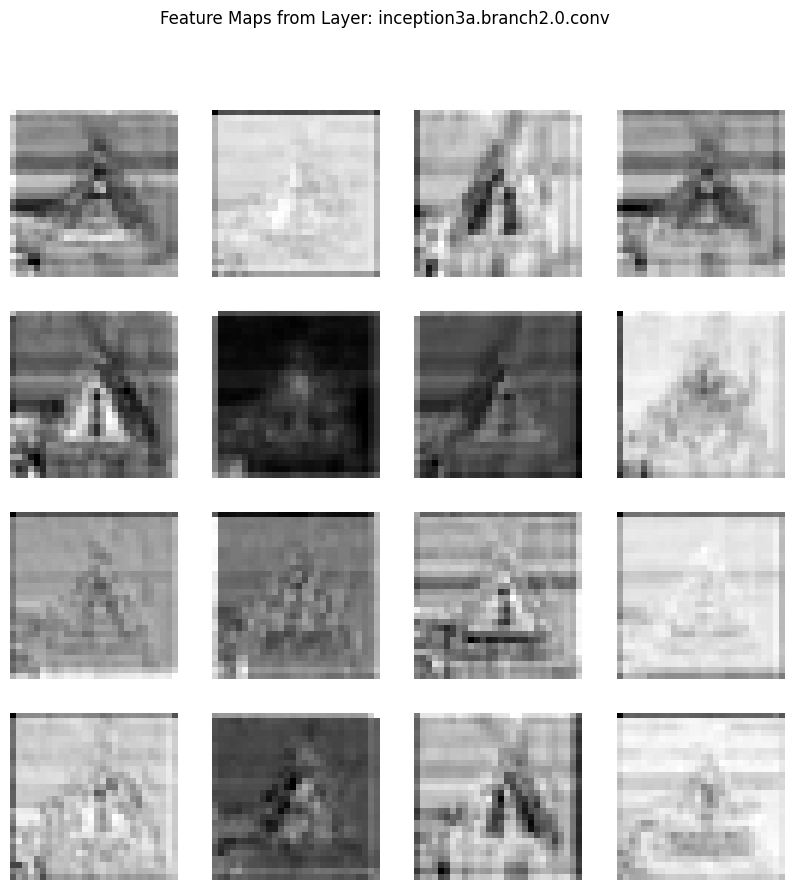

Feature maps for layer: inception3a.branch2.1.conv


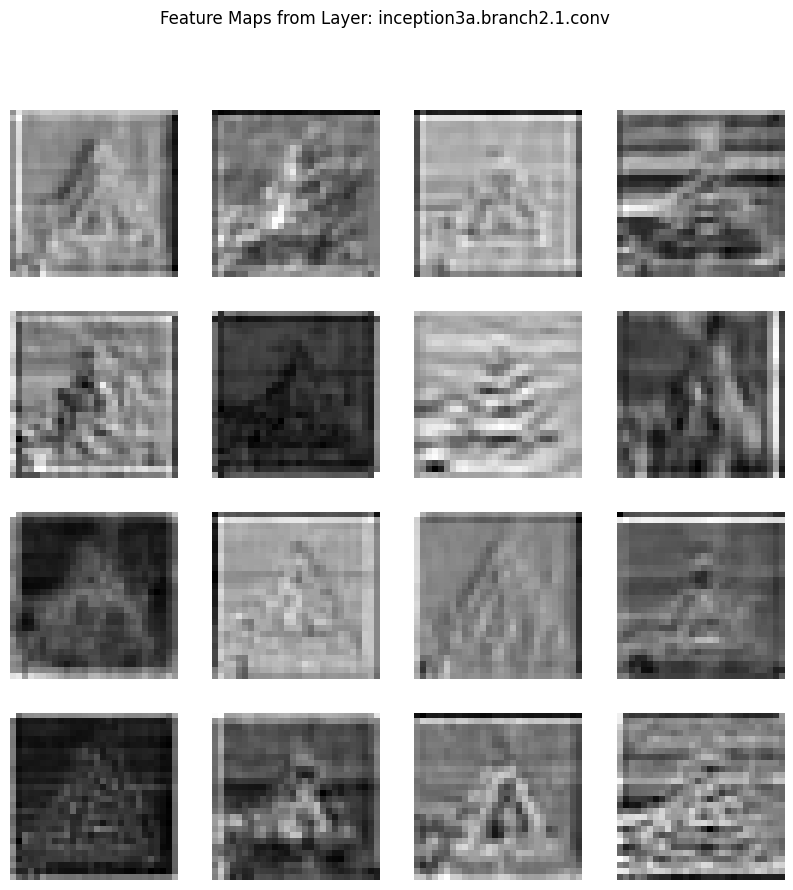

Feature maps for layer: inception3a.branch3.0.conv


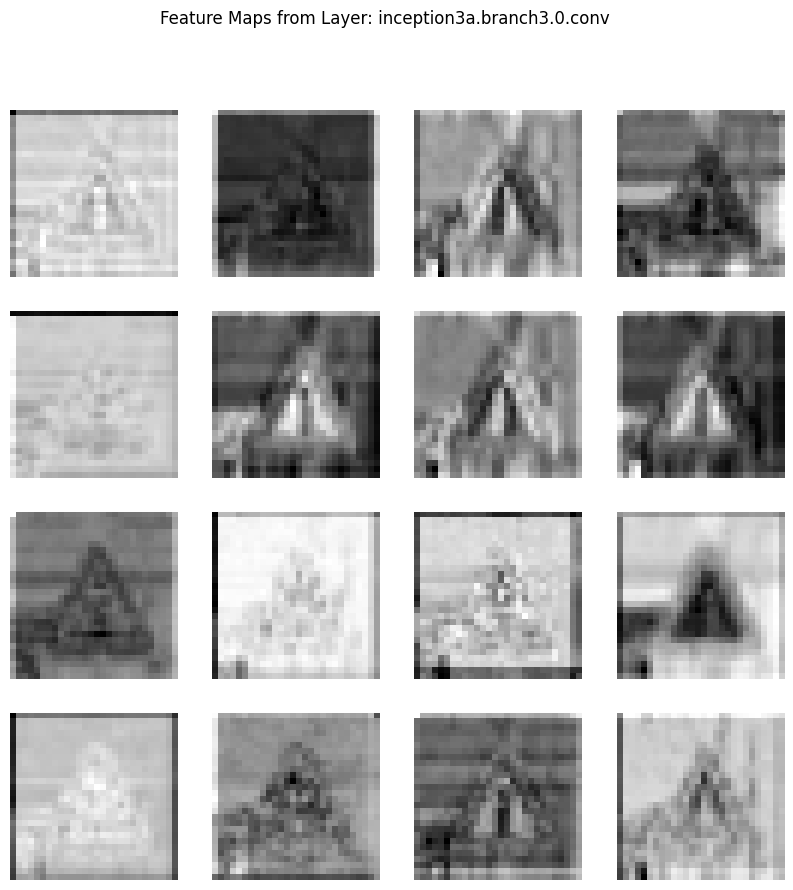

Feature maps for layer: inception3a.branch3.1.conv


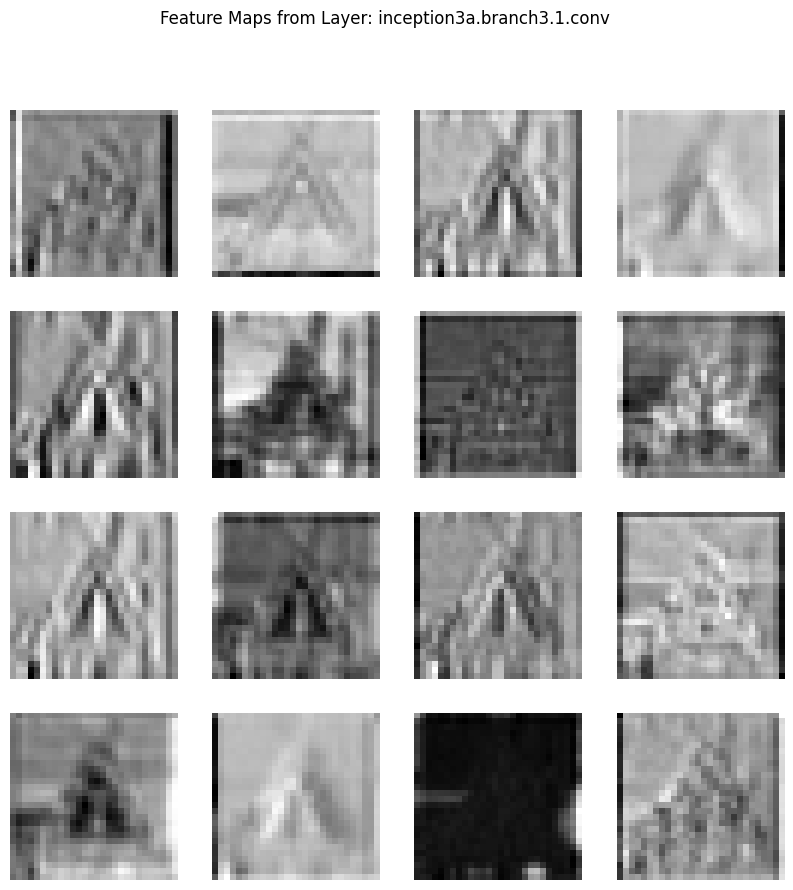

Feature maps for layer: inception3a.branch4.1.conv


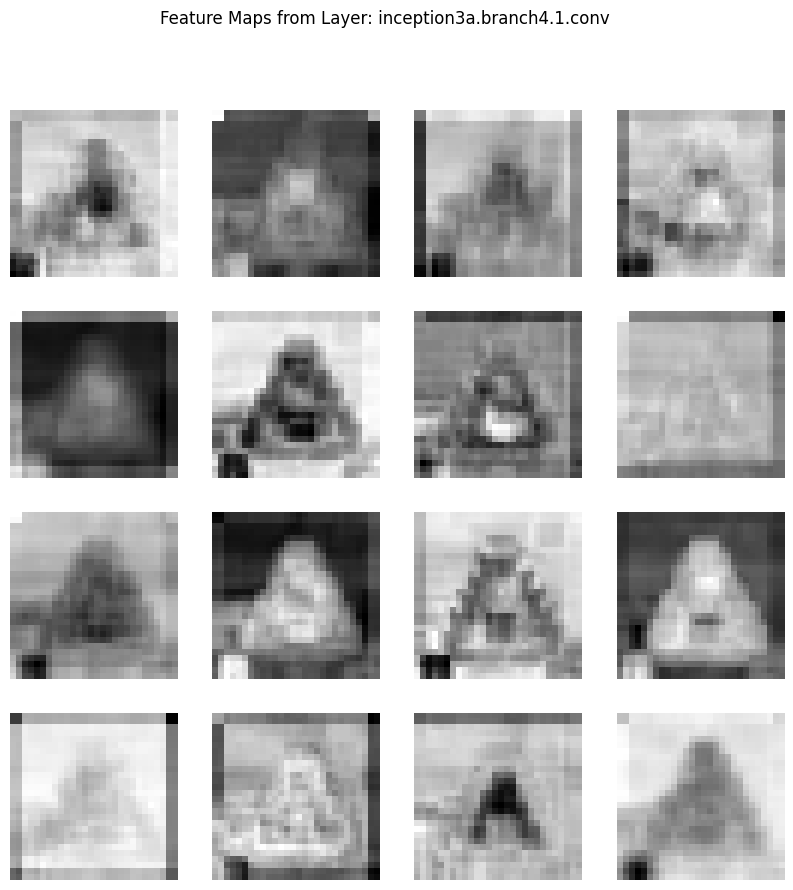

Feature maps for layer: inception3b.branch1.conv


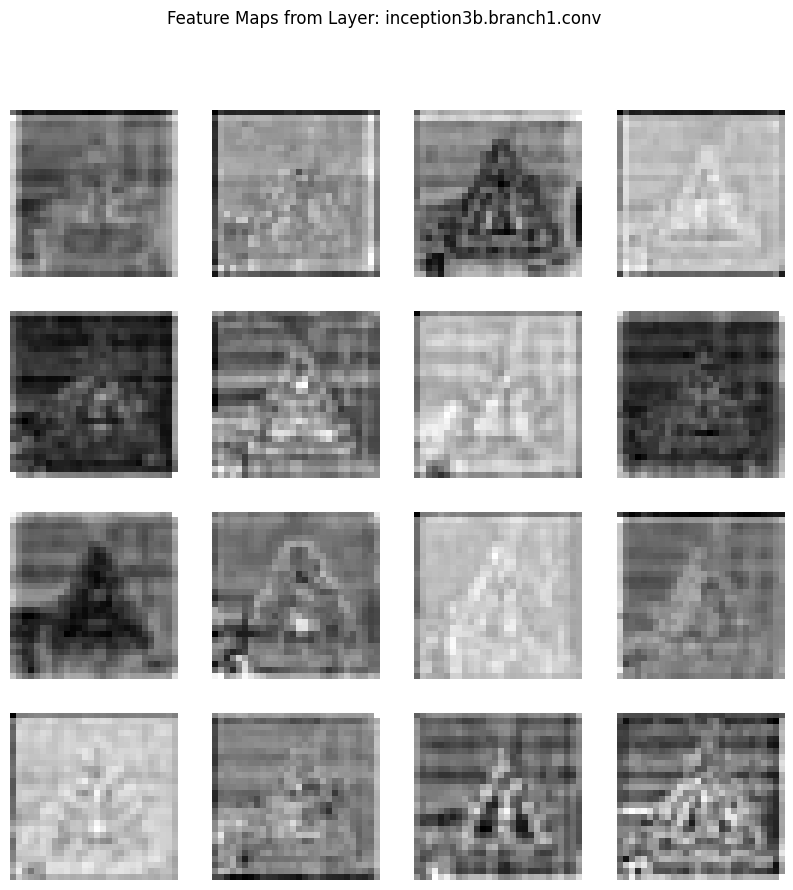

Feature maps for layer: inception3b.branch2.0.conv


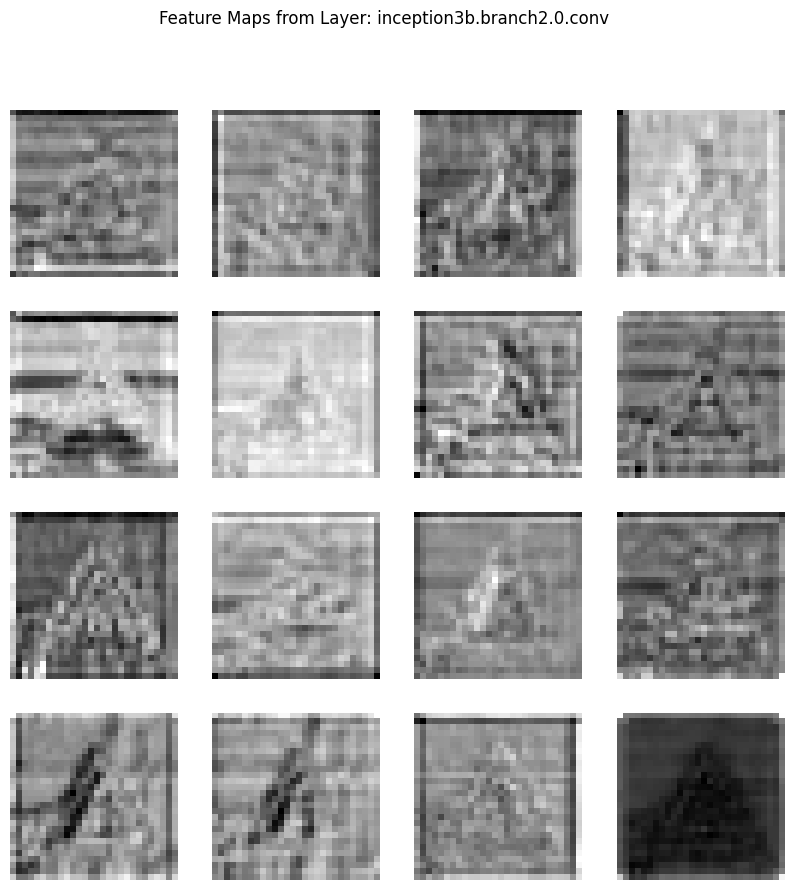

Feature maps for layer: inception3b.branch2.1.conv


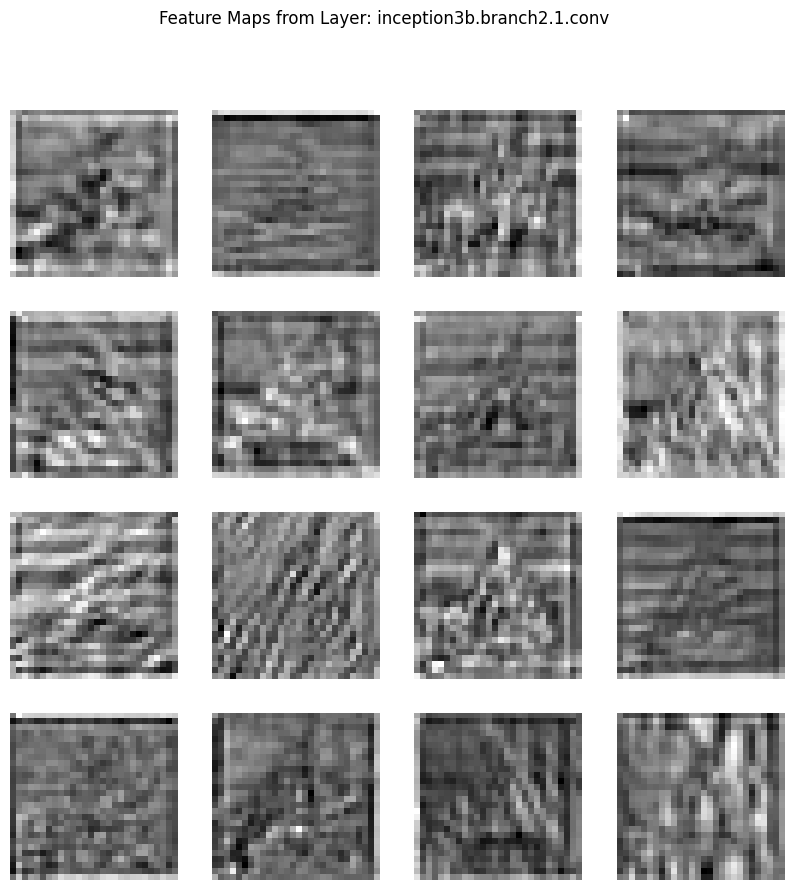

Feature maps for layer: inception3b.branch3.0.conv


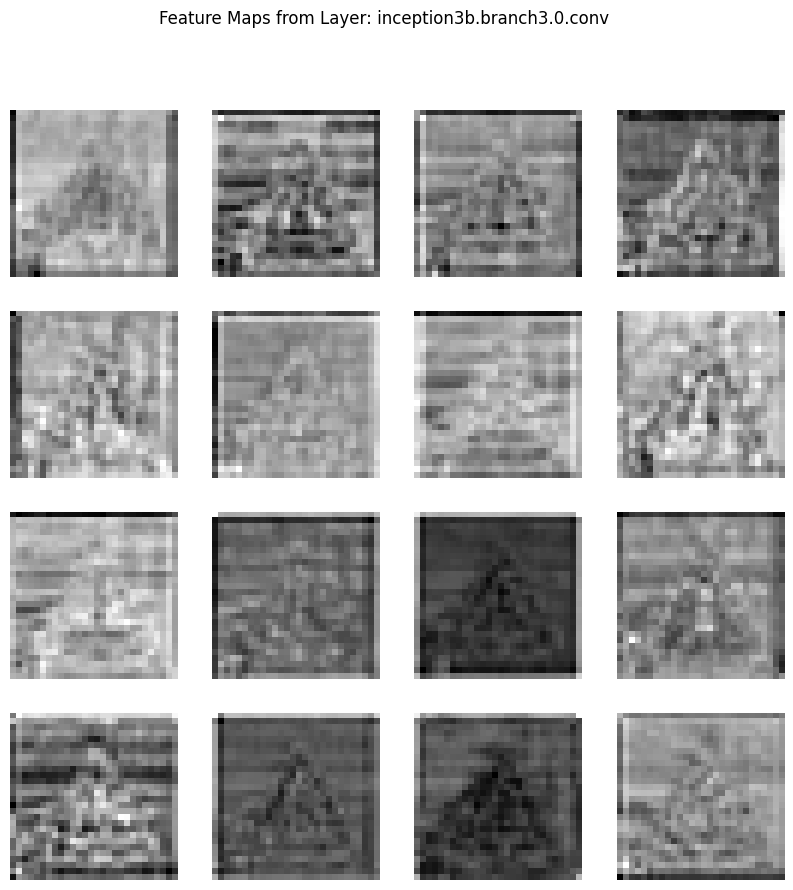

Feature maps for layer: inception3b.branch3.1.conv


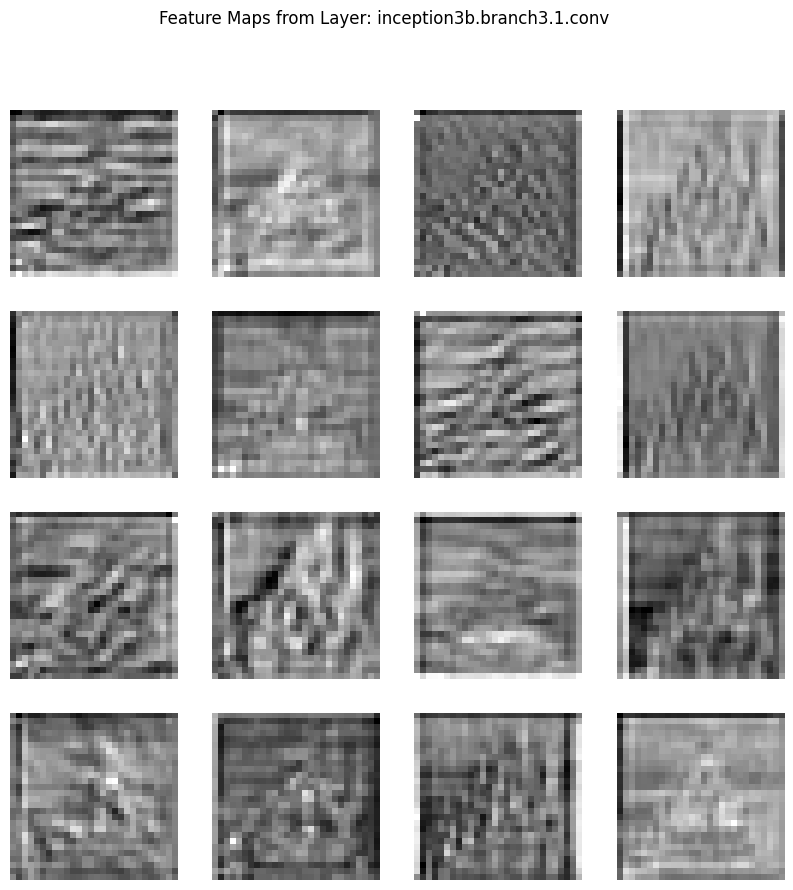

Feature maps for layer: inception3b.branch4.1.conv


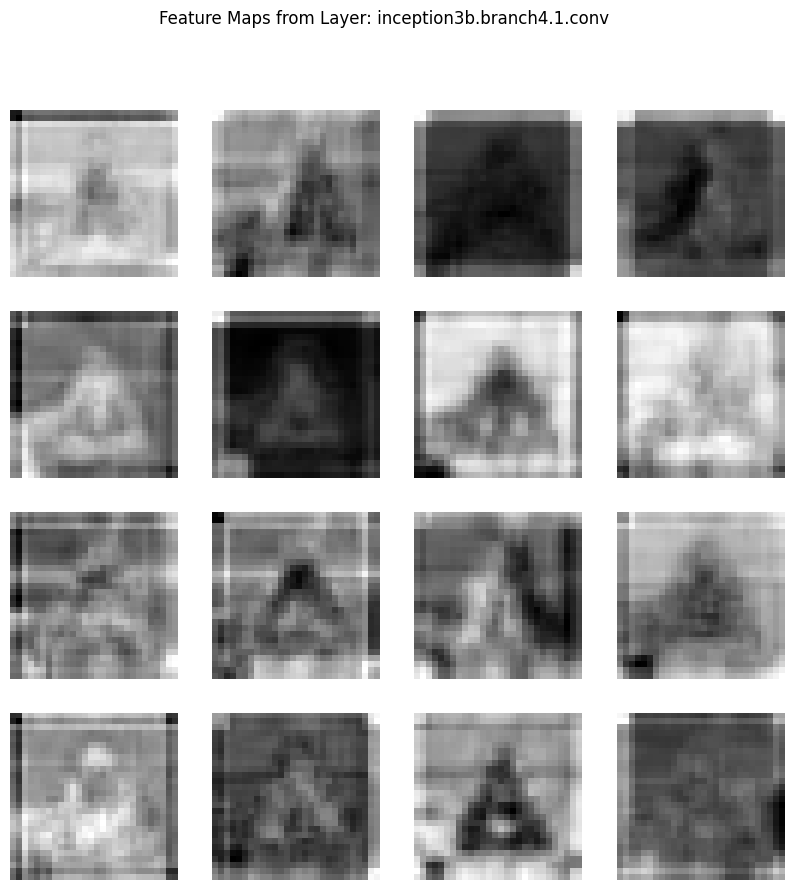

Feature maps for layer: inception4a.branch1.conv


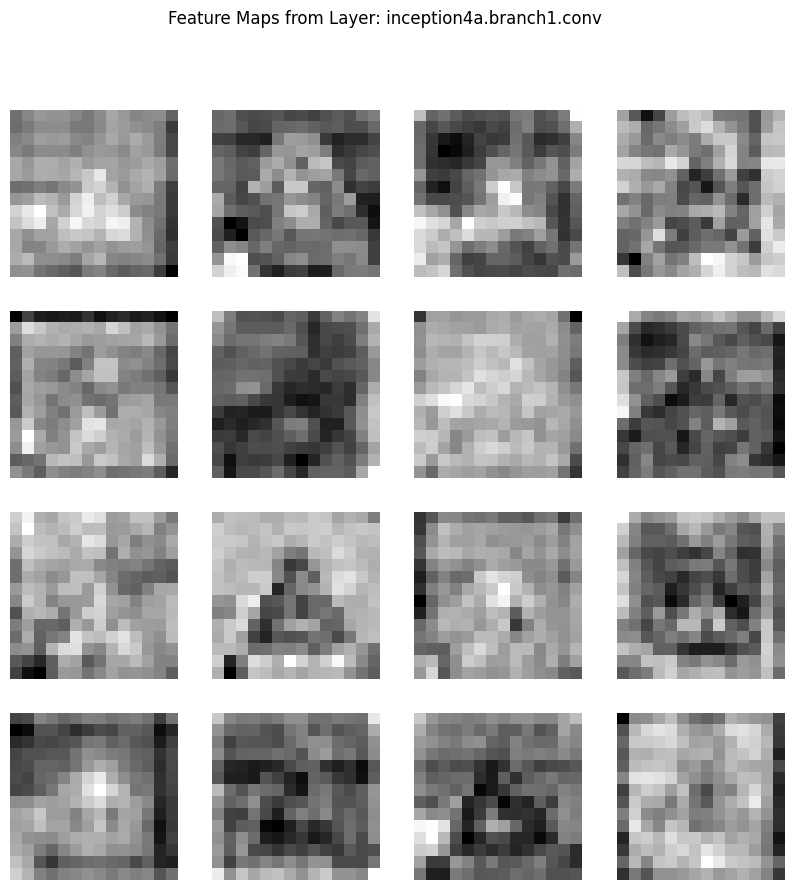

Feature maps for layer: inception4a.branch2.0.conv


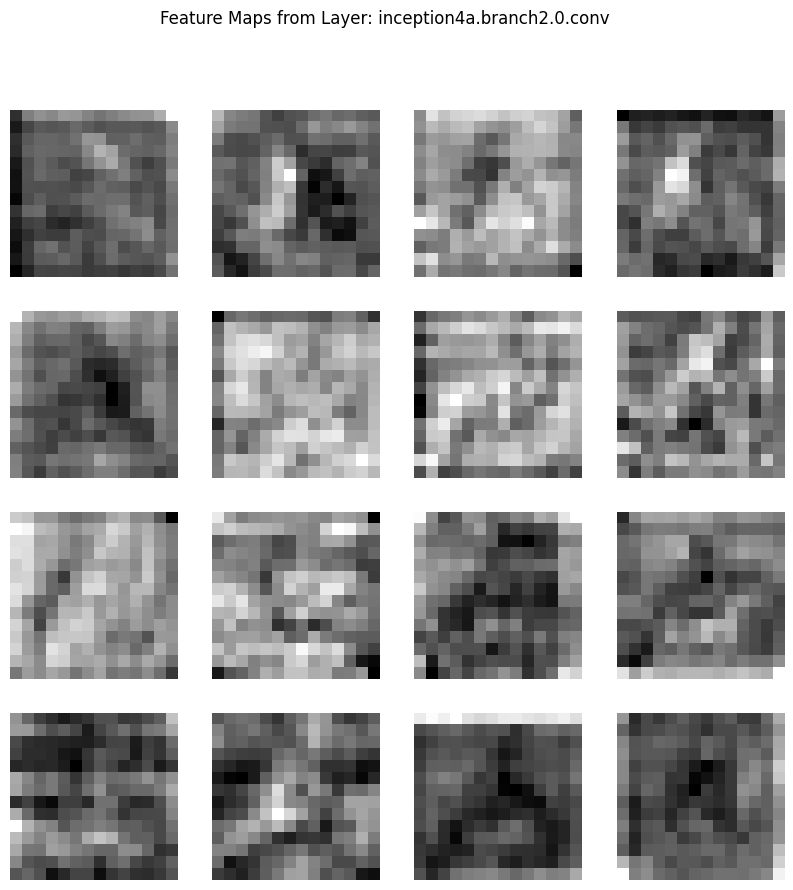

Feature maps for layer: inception4a.branch2.1.conv


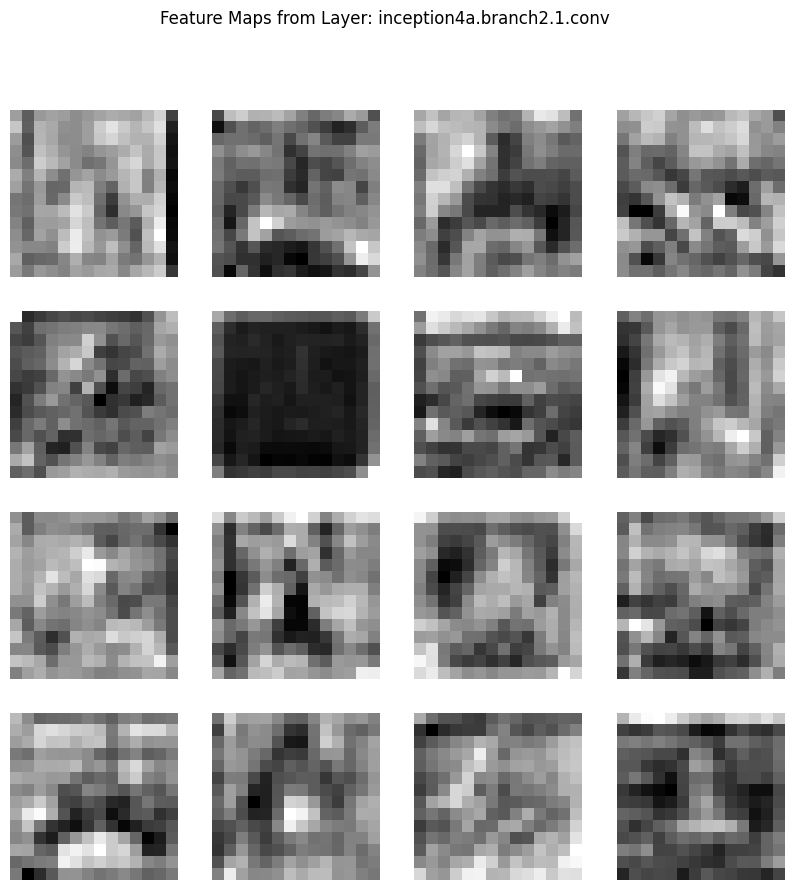

Feature maps for layer: inception4a.branch3.0.conv


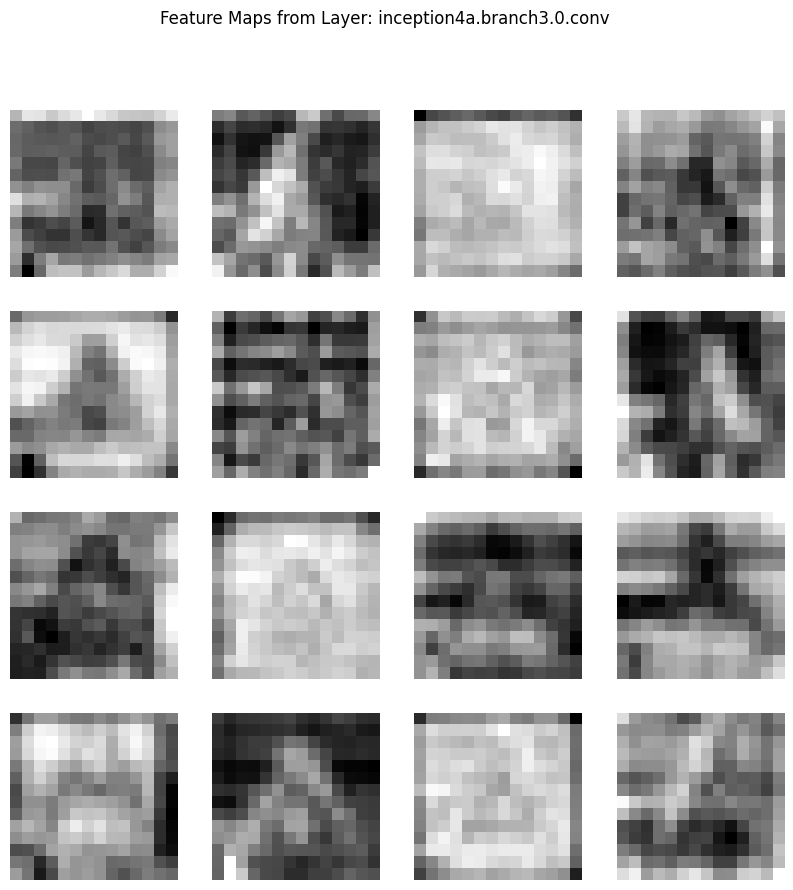

Feature maps for layer: inception4a.branch3.1.conv


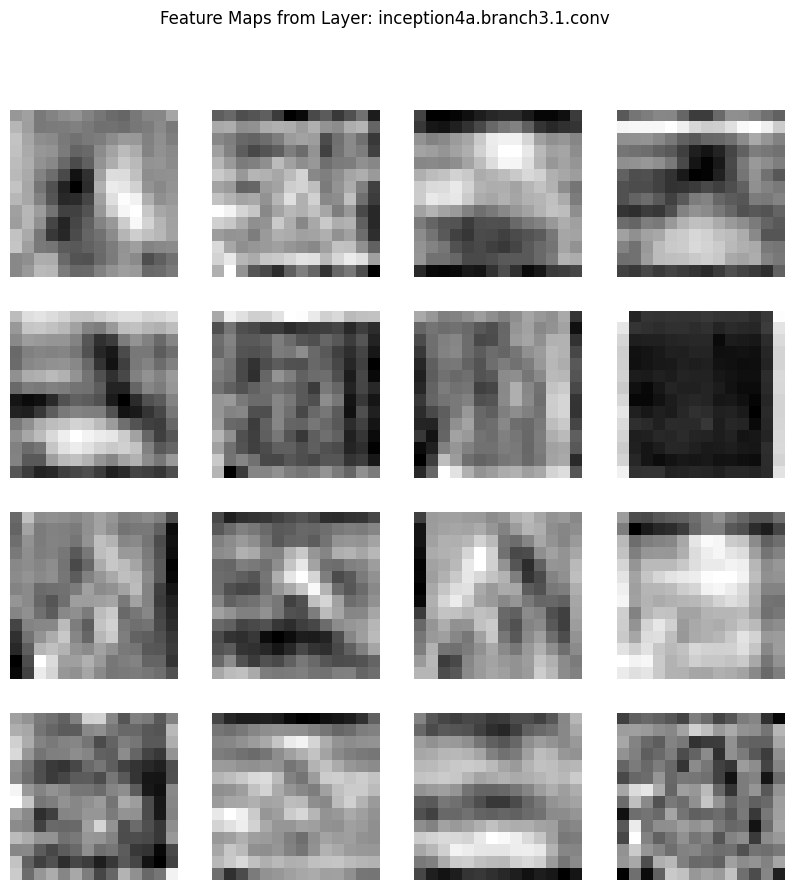

Feature maps for layer: inception4a.branch4.1.conv


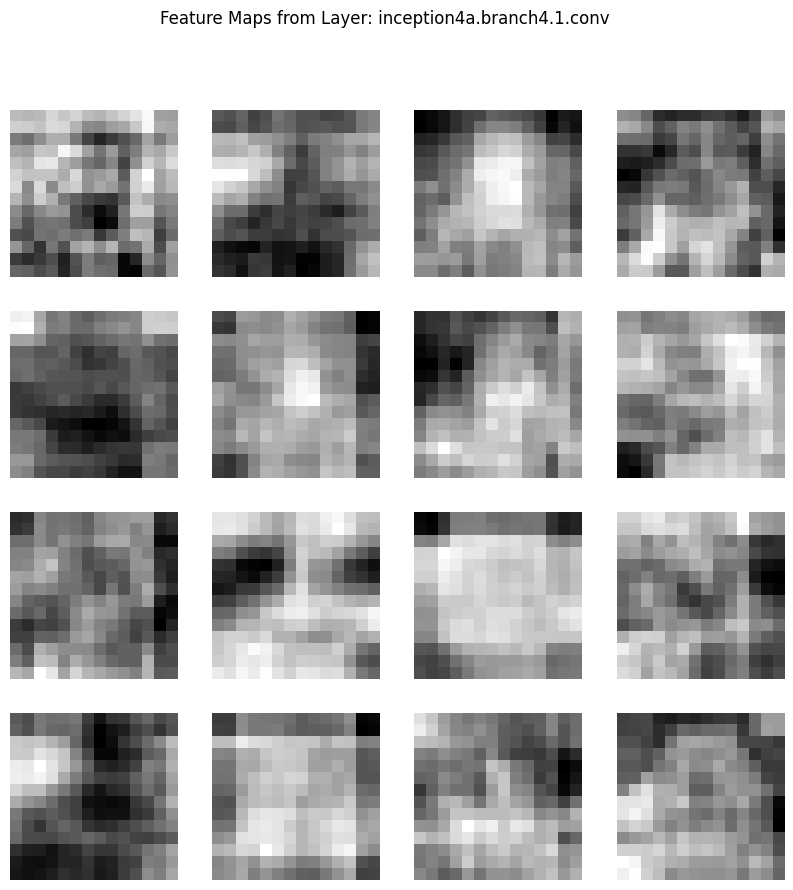

Feature maps for layer: inception4b.branch1.conv


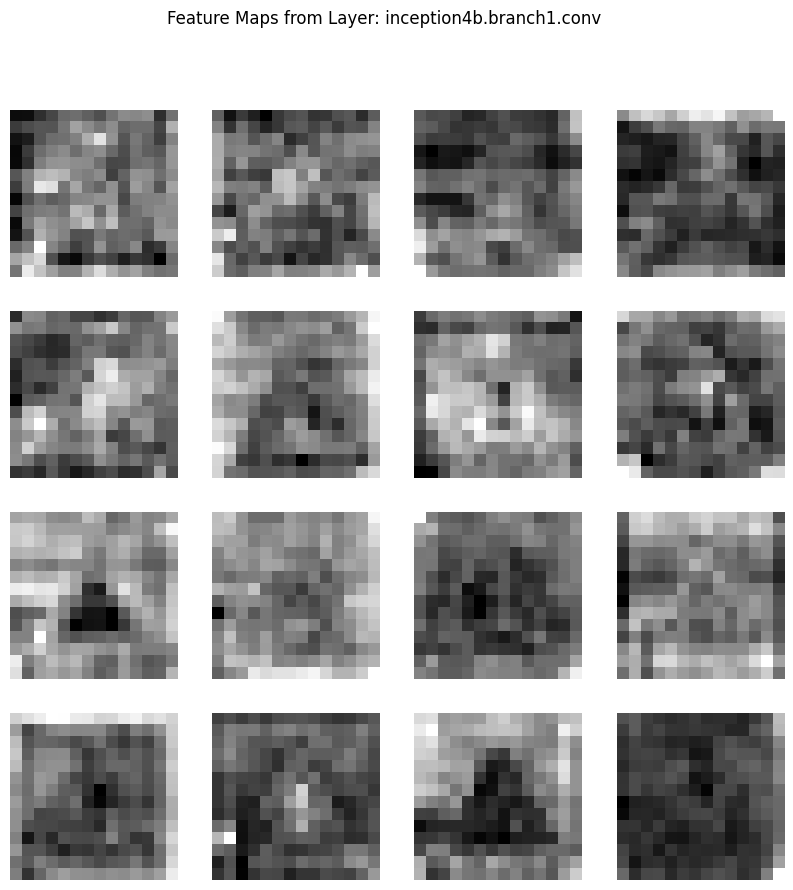

Feature maps for layer: inception4b.branch2.0.conv


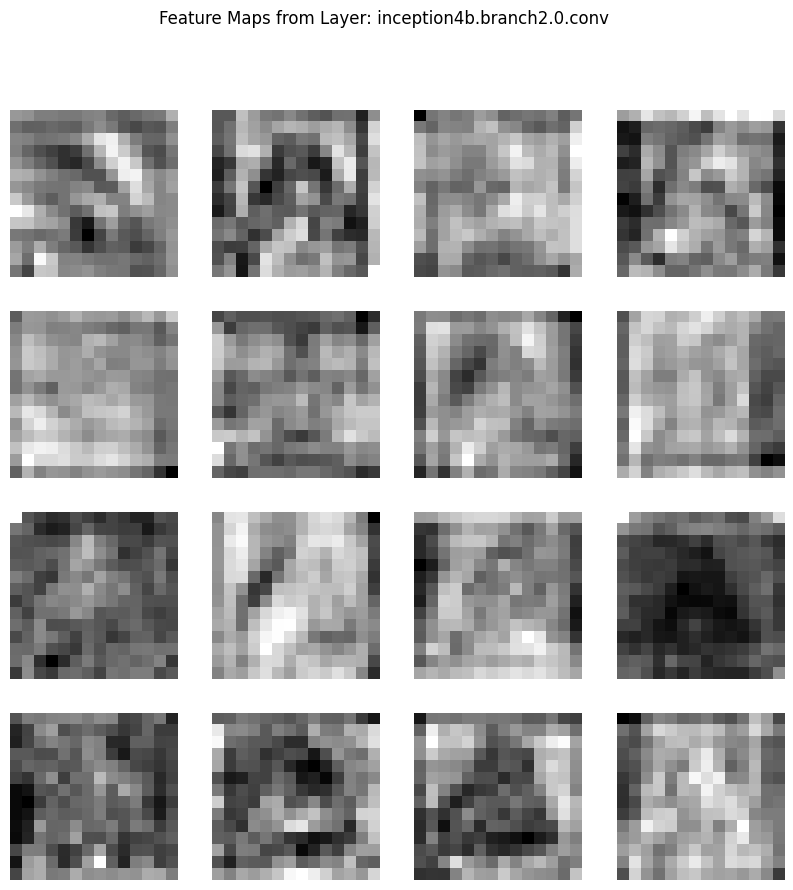

Feature maps for layer: inception4b.branch2.1.conv


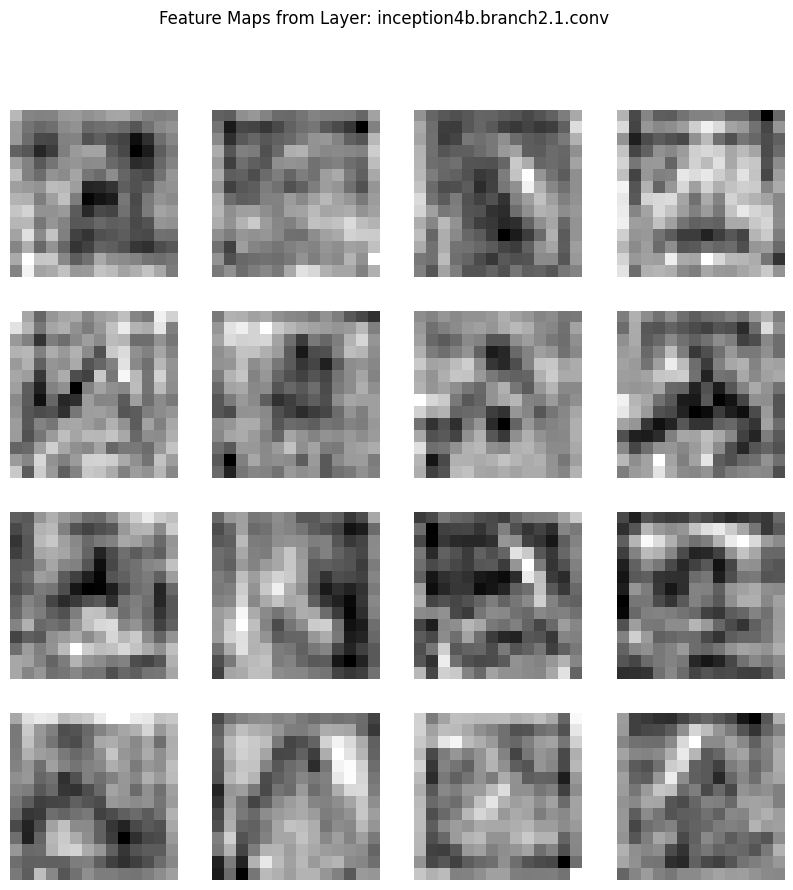

Feature maps for layer: inception4b.branch3.0.conv


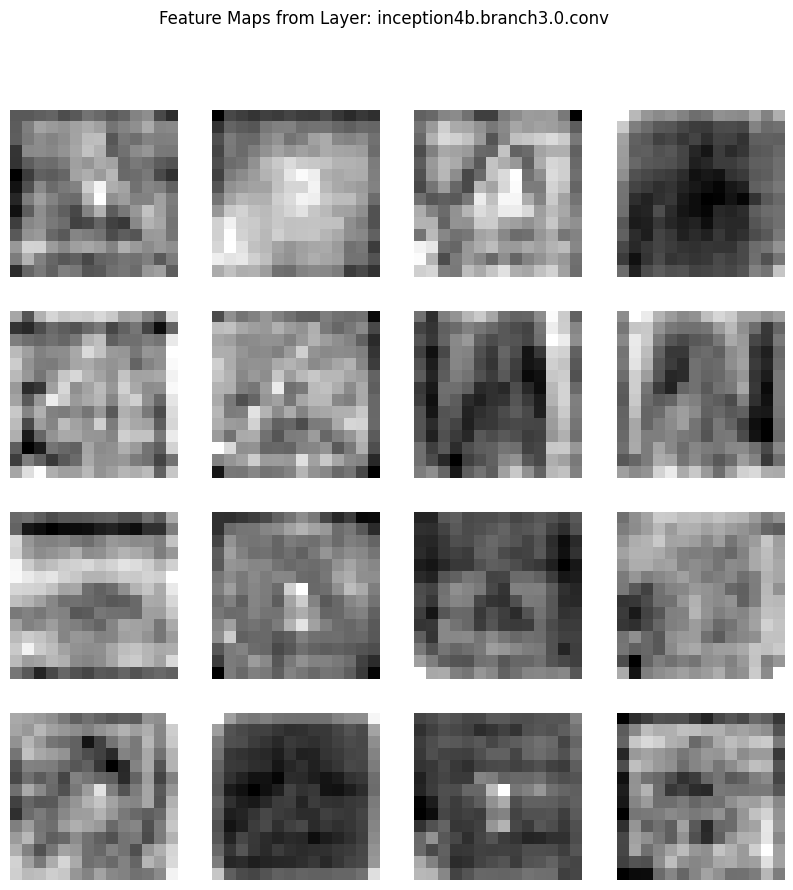

Feature maps for layer: inception4b.branch3.1.conv


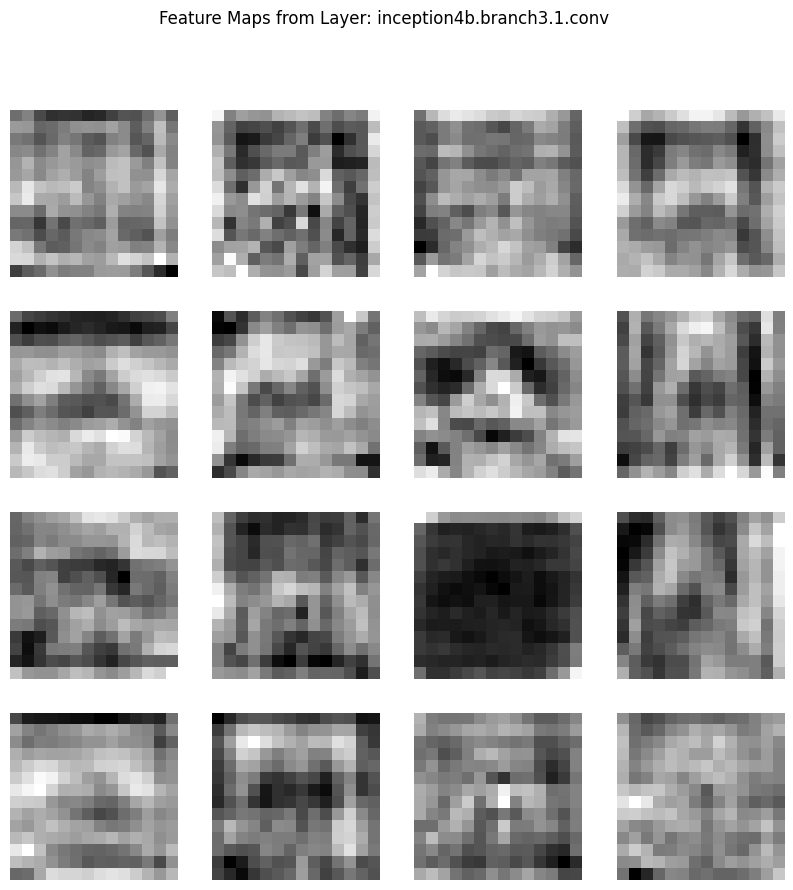

Feature maps for layer: inception4b.branch4.1.conv


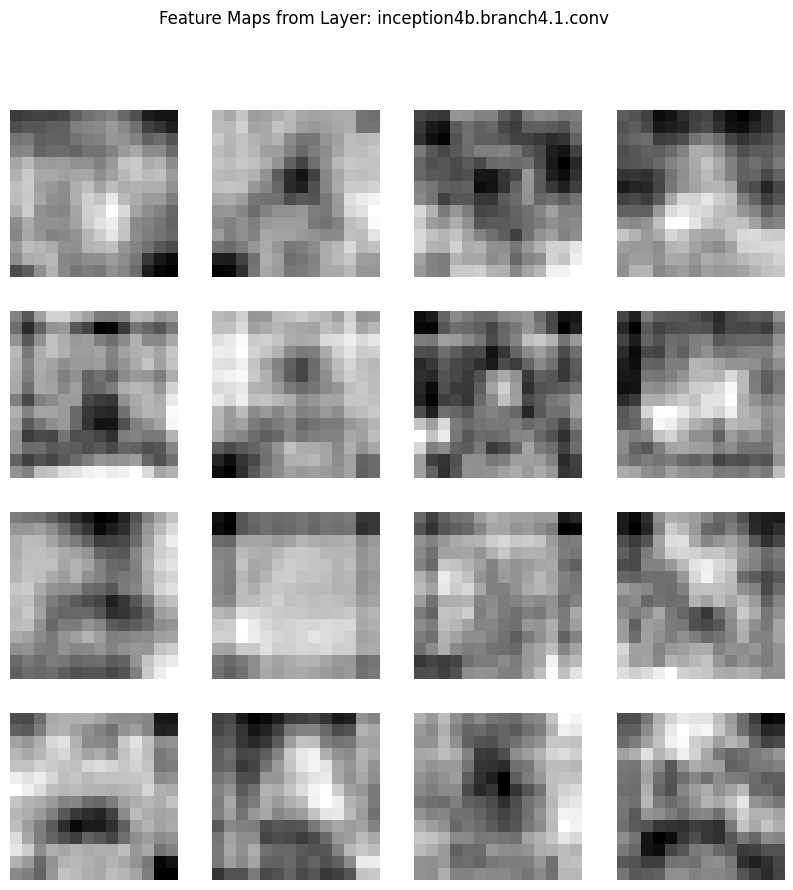

Feature maps for layer: inception4c.branch1.conv


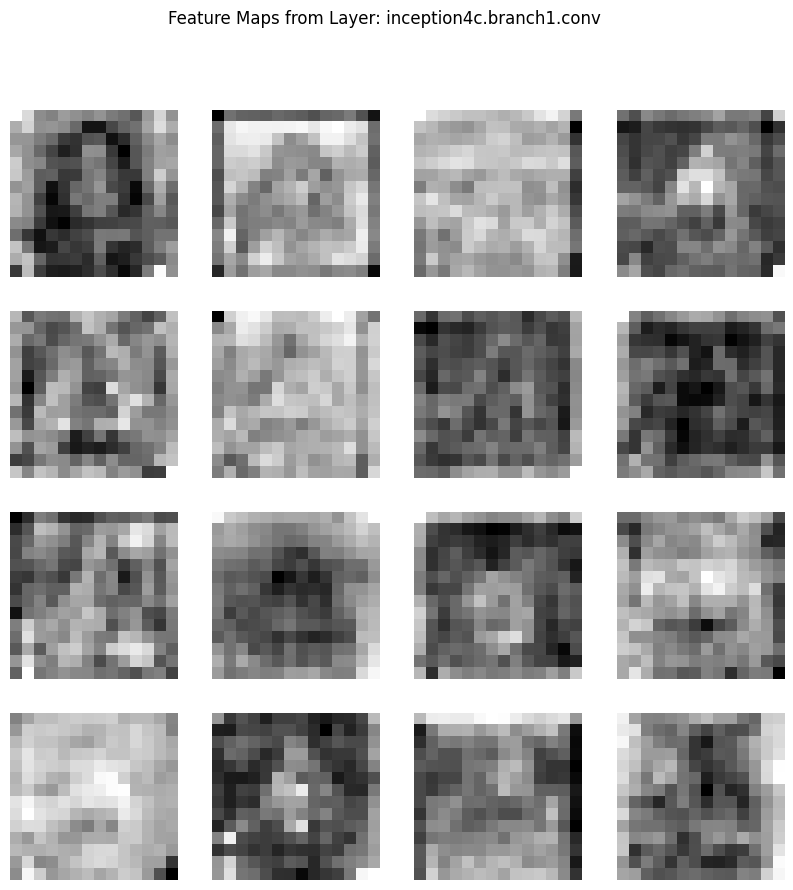

Feature maps for layer: inception4c.branch2.0.conv


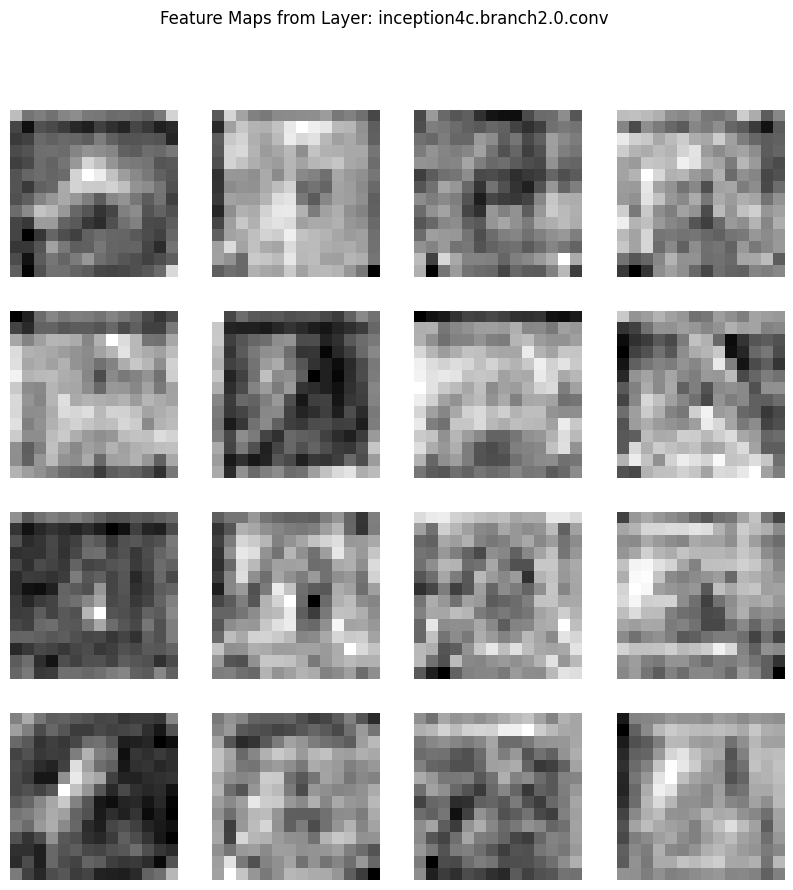

Feature maps for layer: inception4c.branch2.1.conv


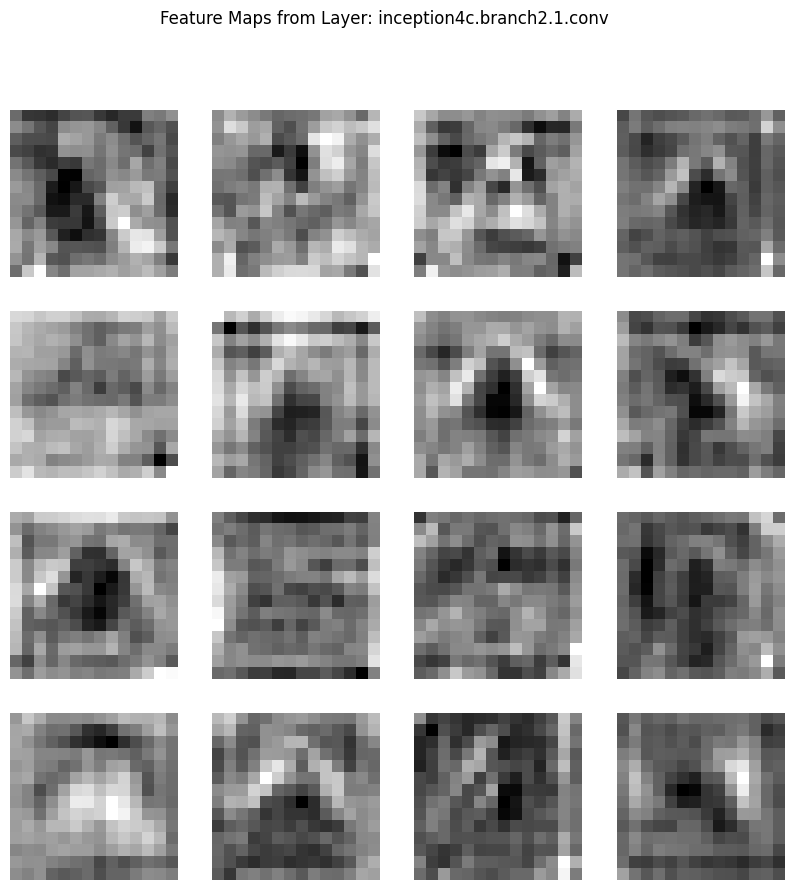

Feature maps for layer: inception4c.branch3.0.conv


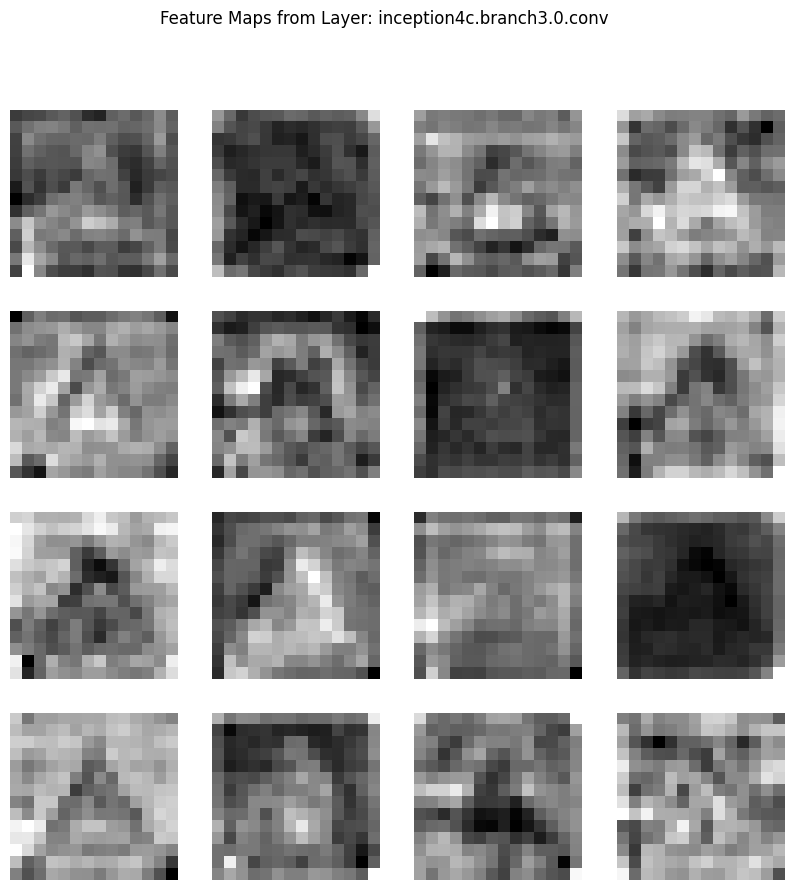

Feature maps for layer: inception4c.branch3.1.conv


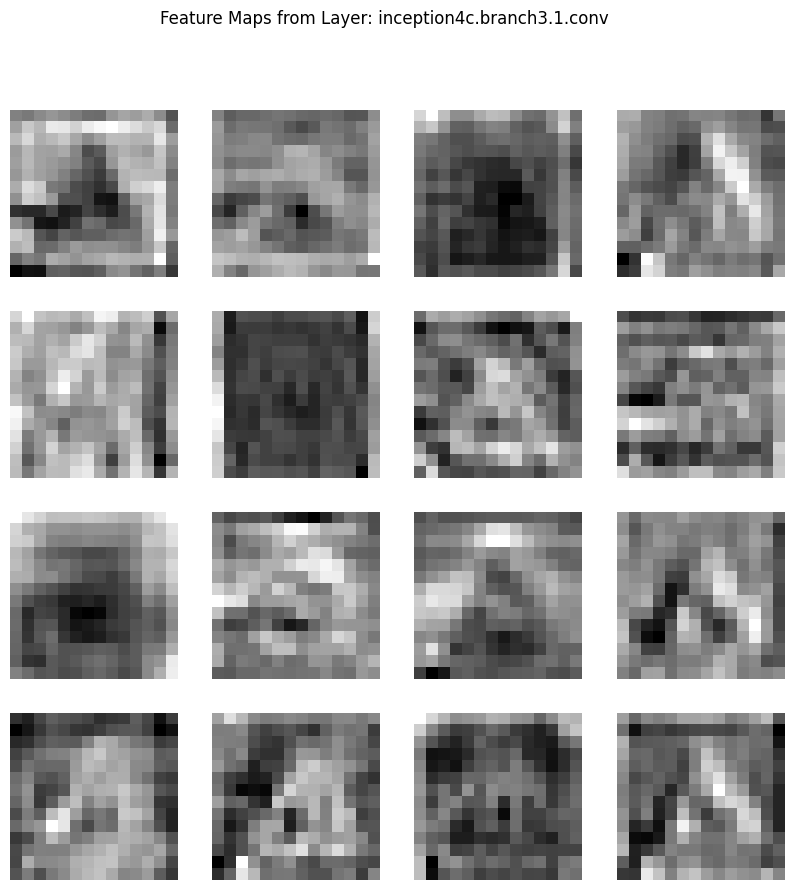

Feature maps for layer: inception4c.branch4.1.conv


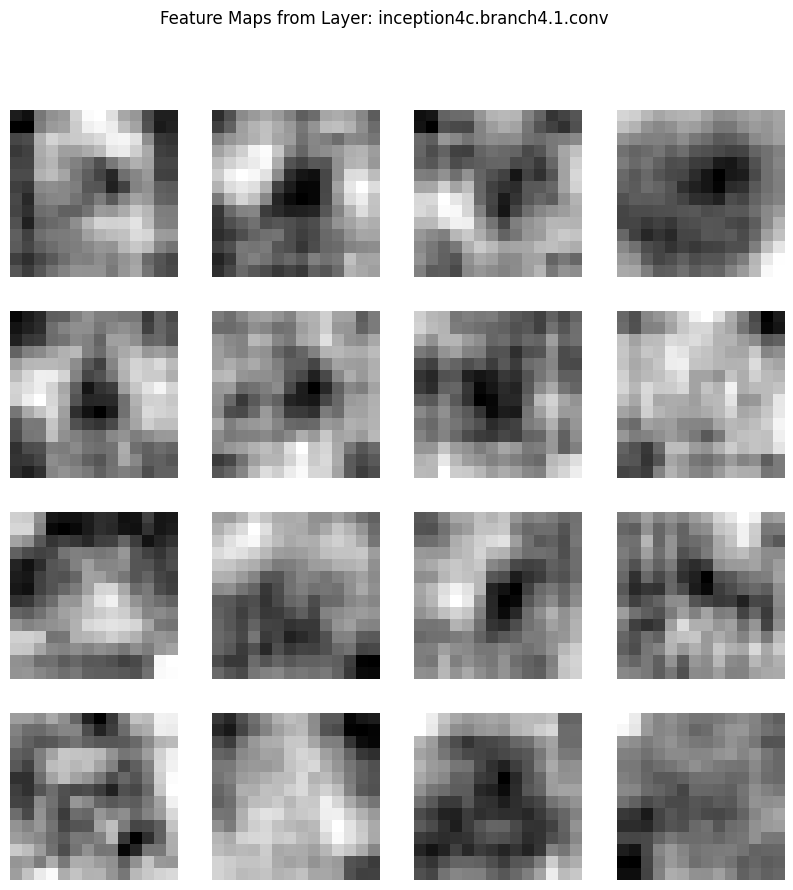

Feature maps for layer: inception4d.branch1.conv


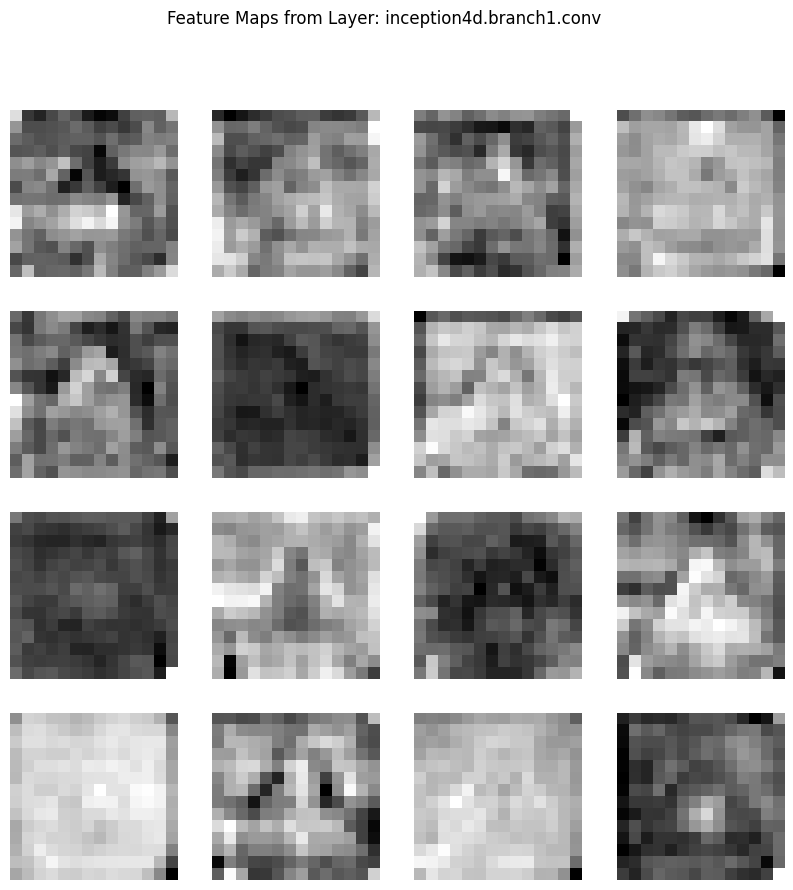

Feature maps for layer: inception4d.branch2.0.conv


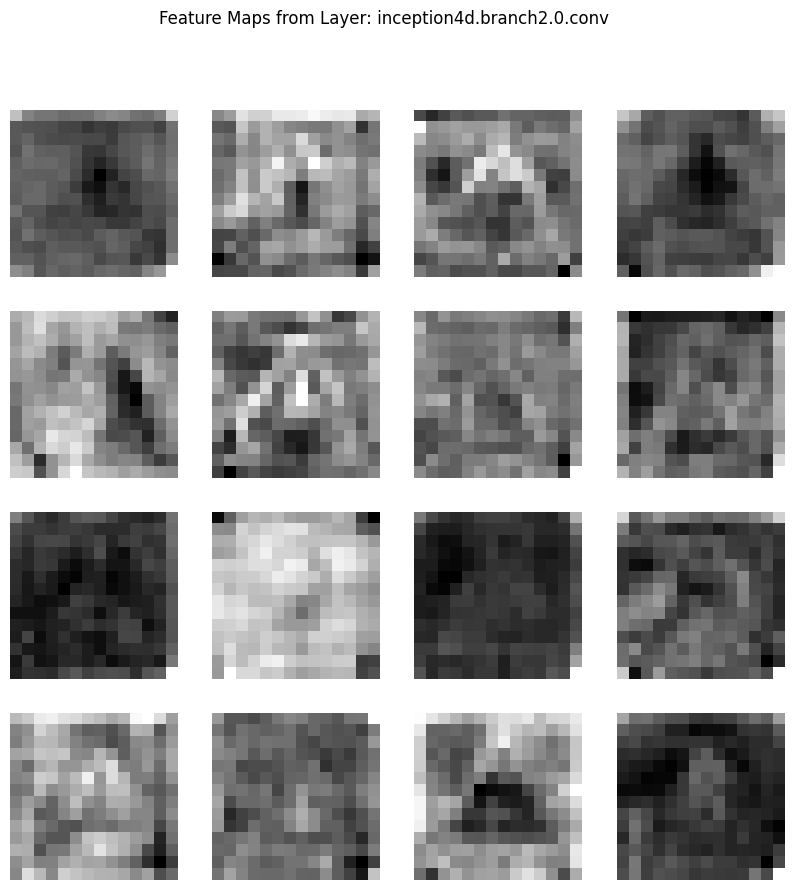

Feature maps for layer: inception4d.branch2.1.conv


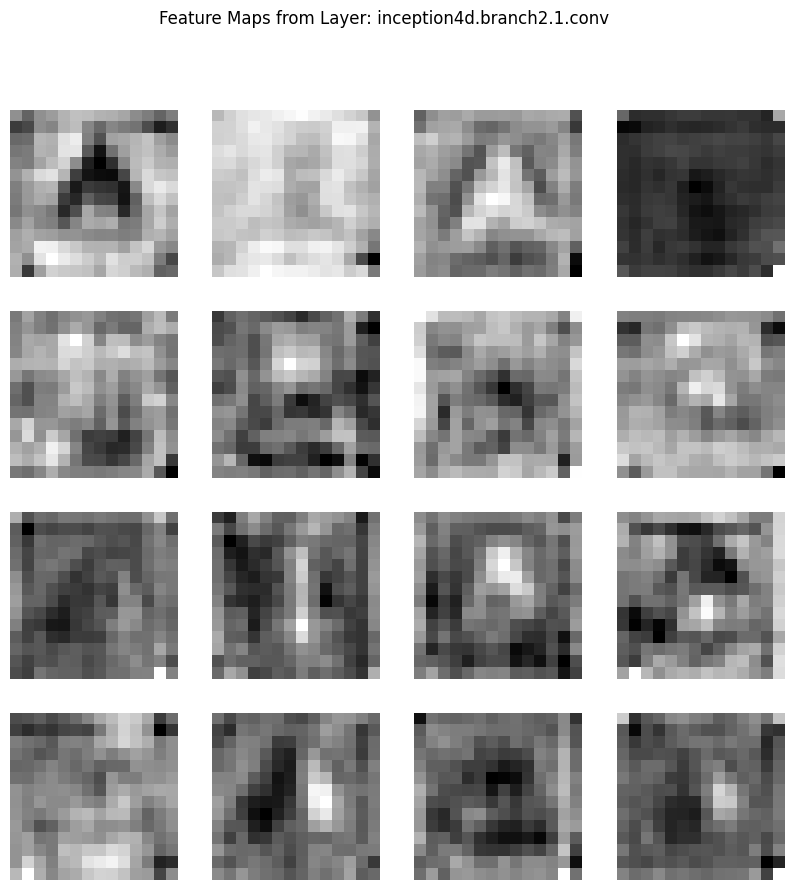

Feature maps for layer: inception4d.branch3.0.conv


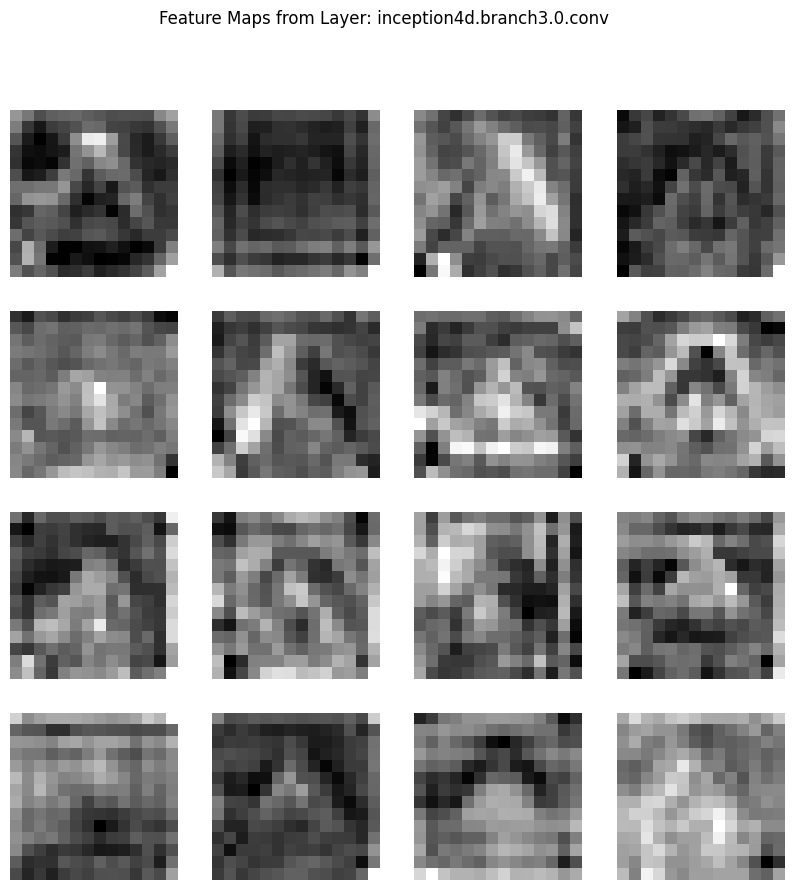

Feature maps for layer: inception4d.branch3.1.conv


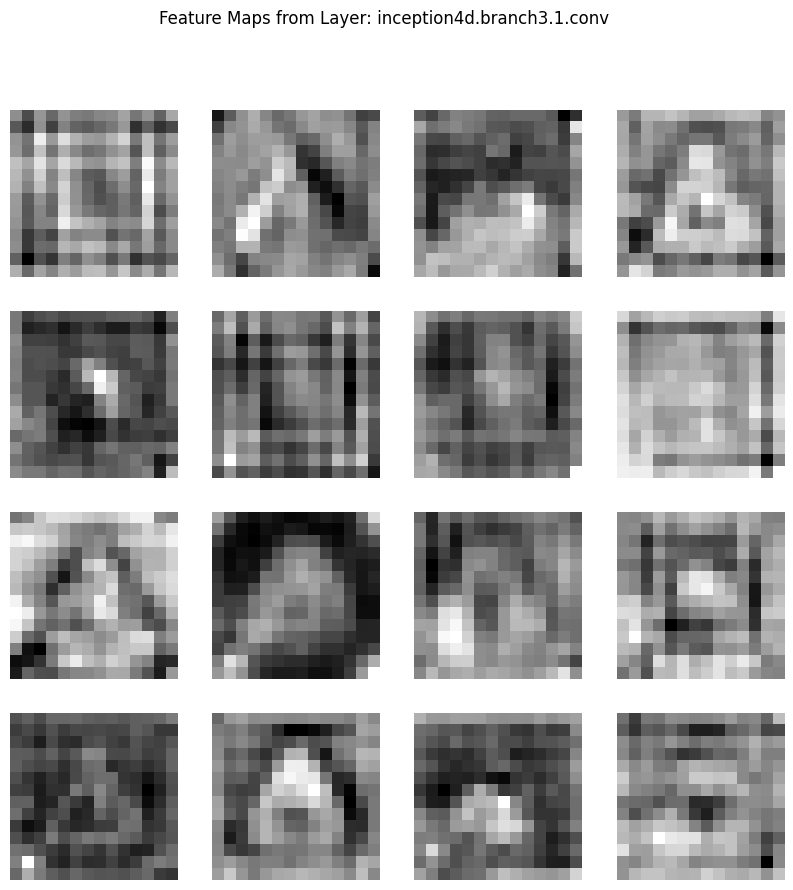

Feature maps for layer: inception4d.branch4.1.conv


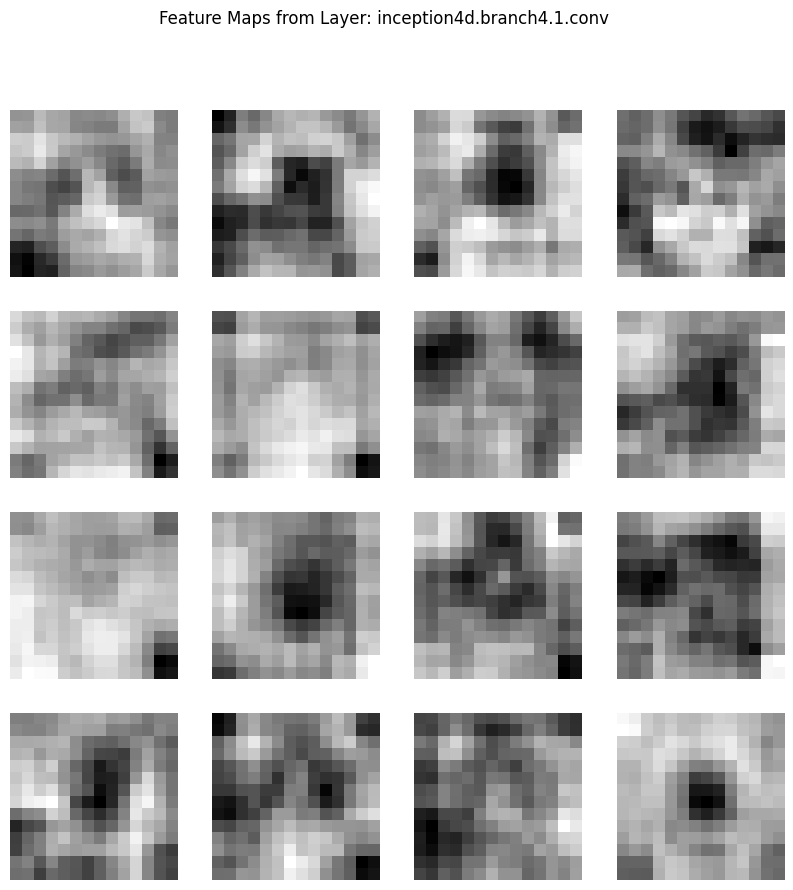

Feature maps for layer: inception4e.branch1.conv


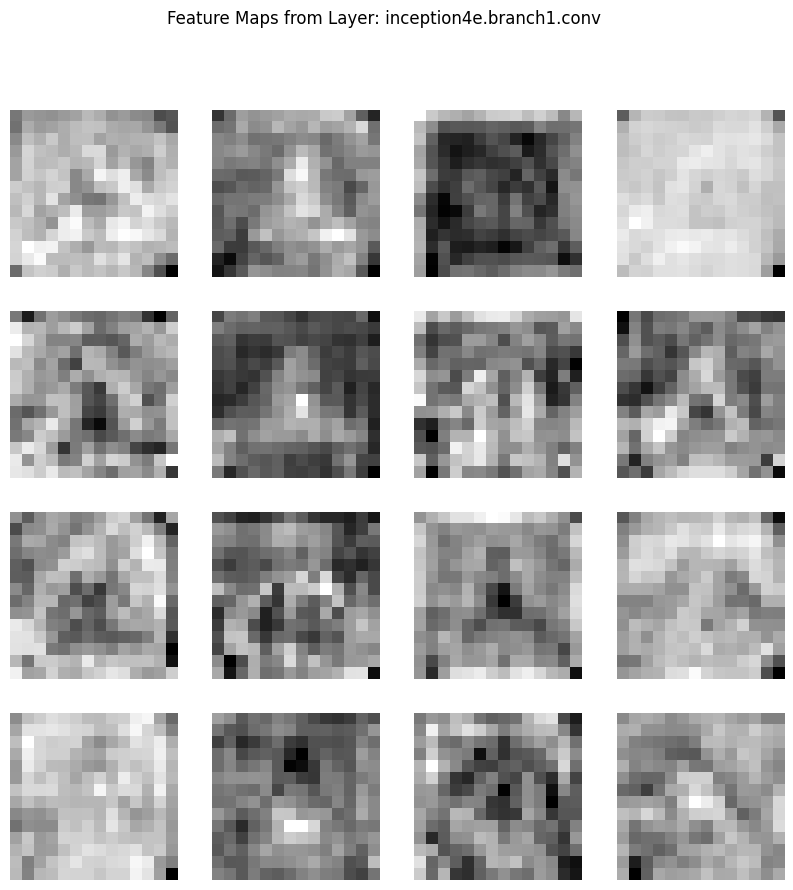

Feature maps for layer: inception4e.branch2.0.conv


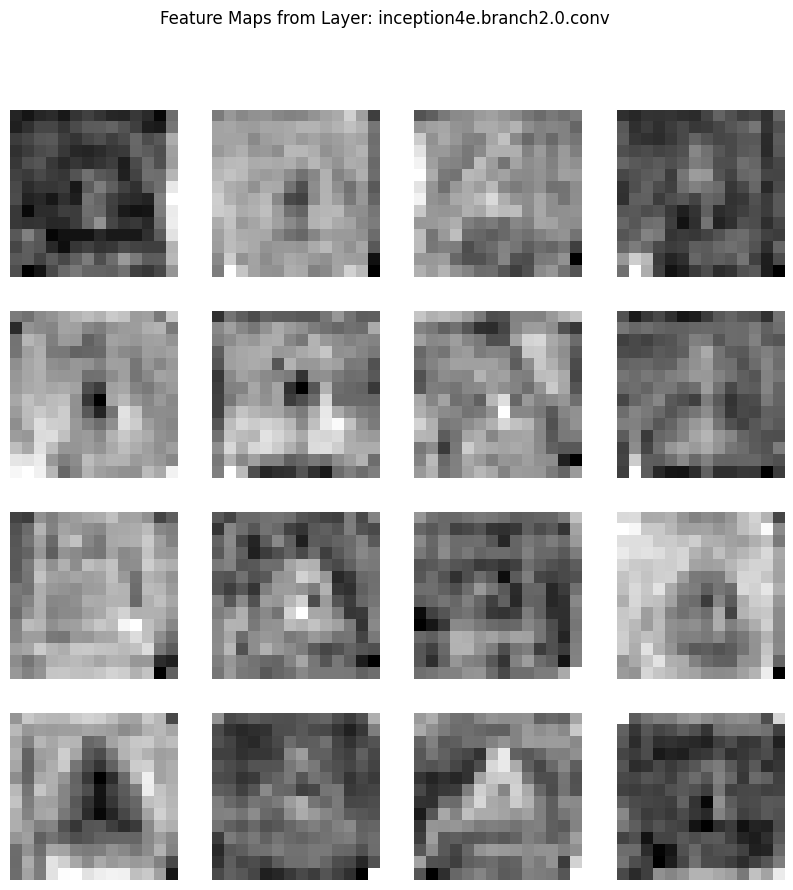

Feature maps for layer: inception4e.branch2.1.conv


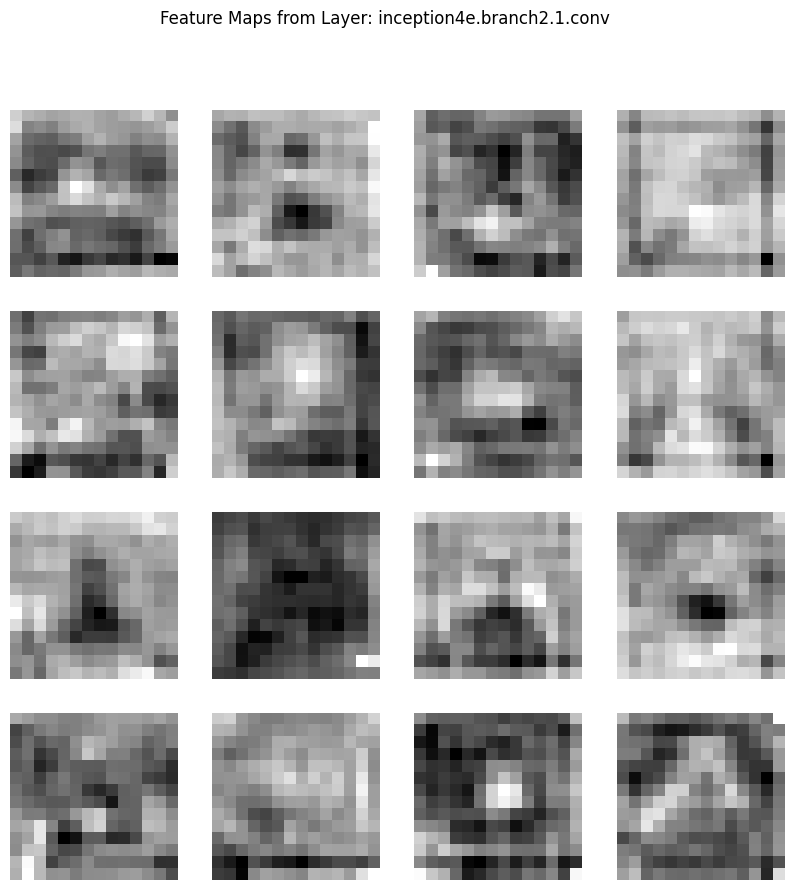

Feature maps for layer: inception4e.branch3.0.conv


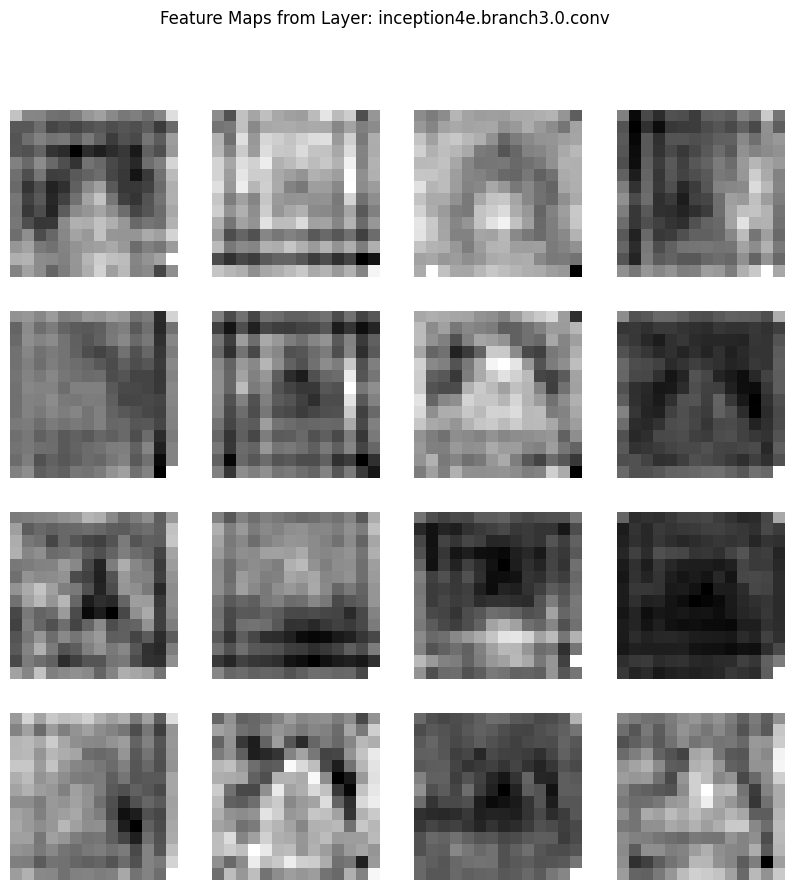

Feature maps for layer: inception4e.branch3.1.conv


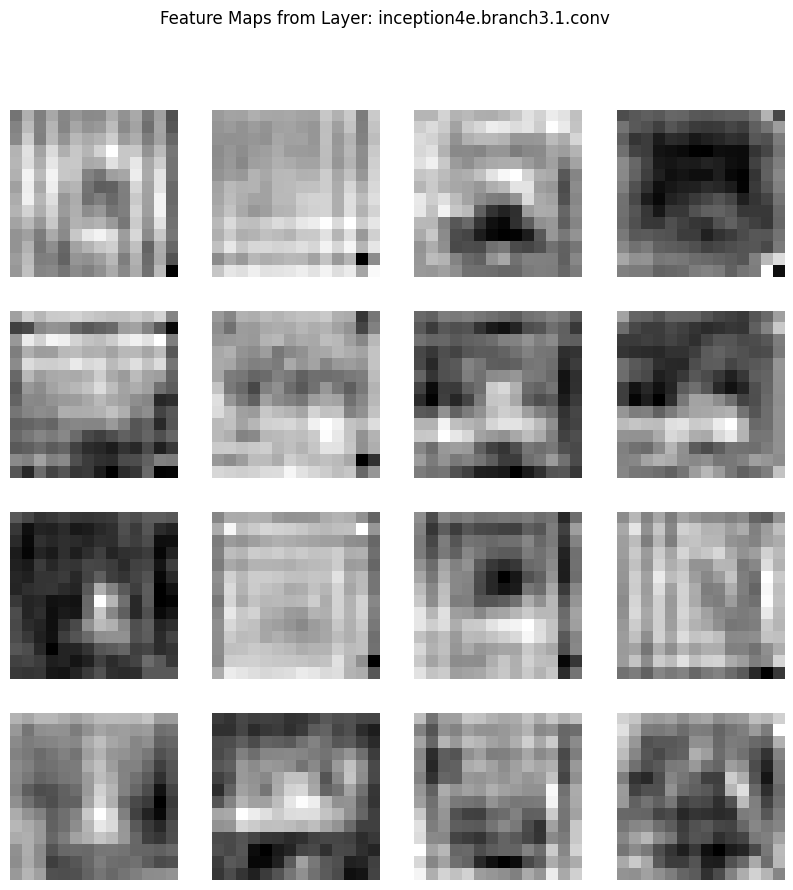

Feature maps for layer: inception4e.branch4.1.conv


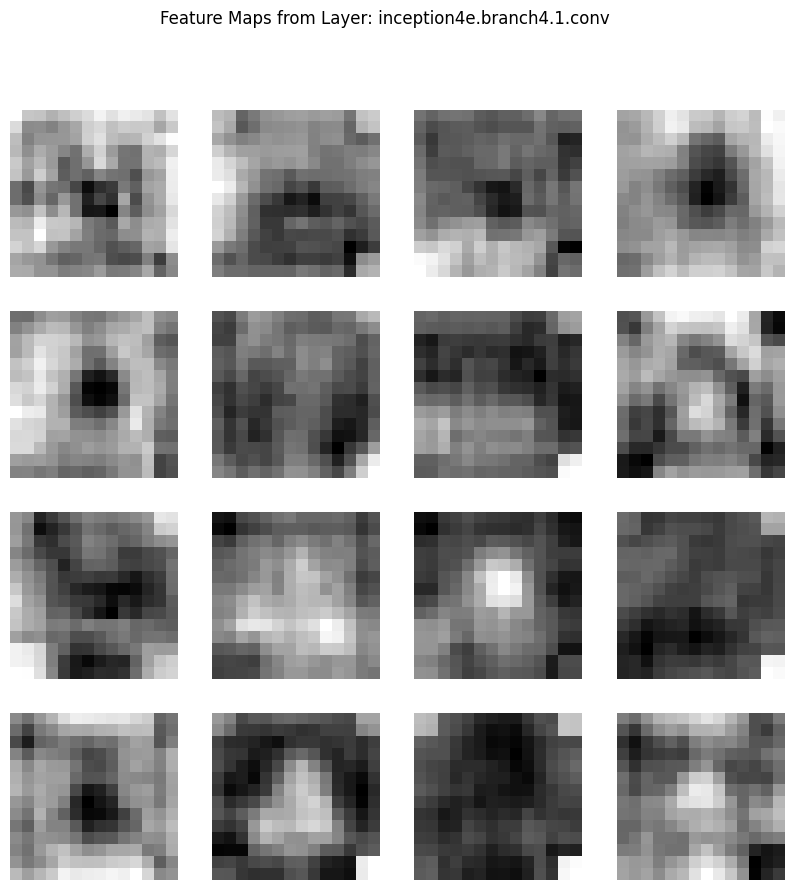

Feature maps for layer: inception5a.branch1.conv


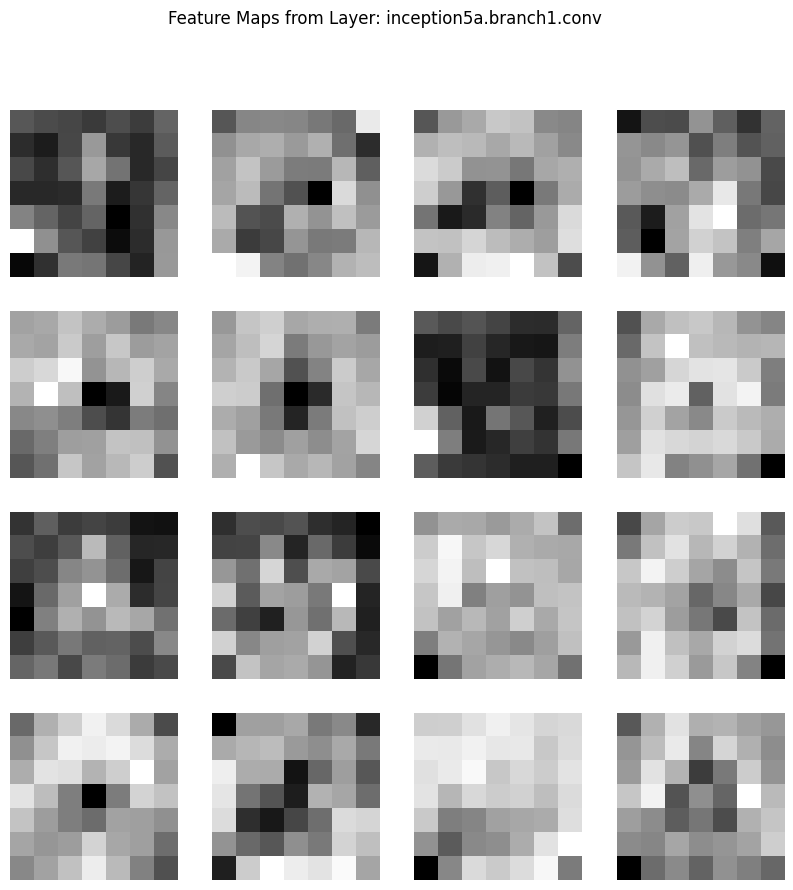

Feature maps for layer: inception5a.branch2.0.conv


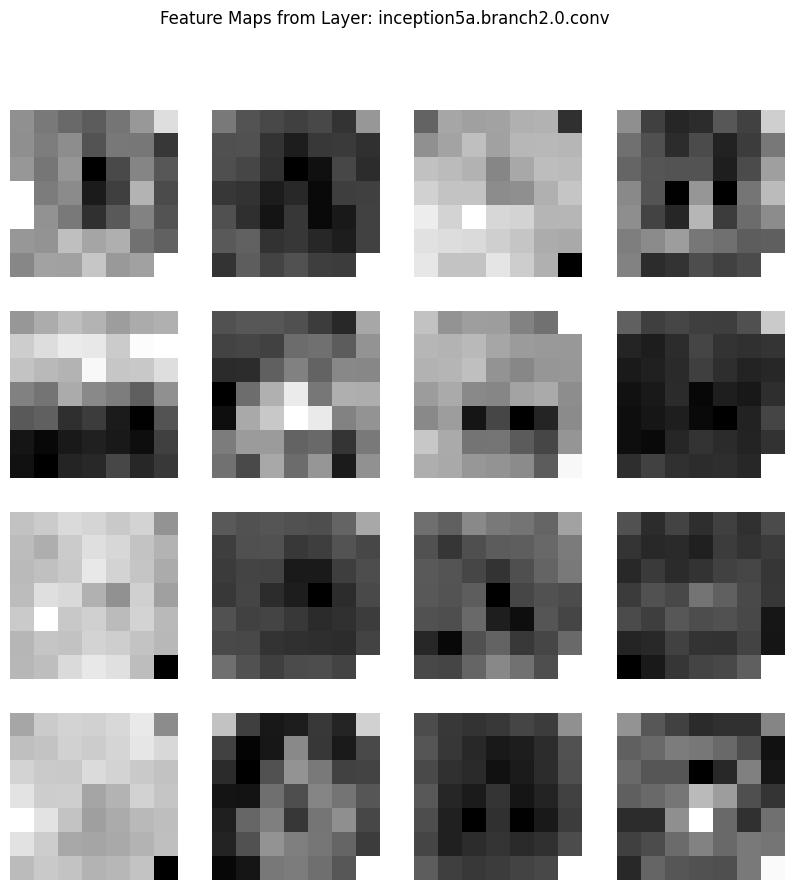

Feature maps for layer: inception5a.branch2.1.conv


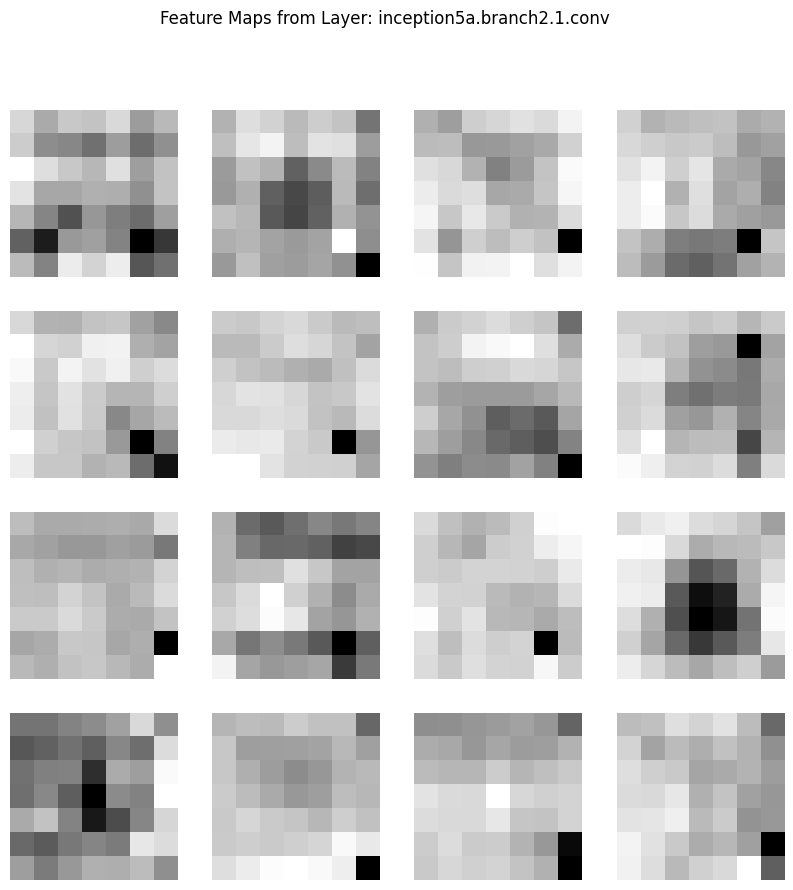

Feature maps for layer: inception5a.branch3.0.conv


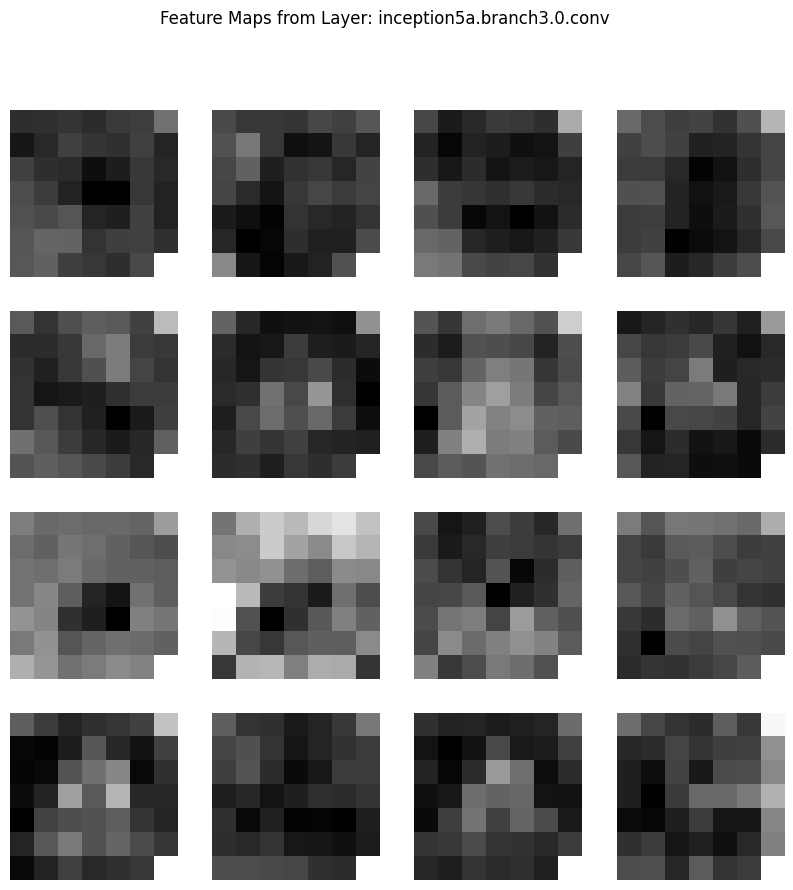

Feature maps for layer: inception5a.branch3.1.conv


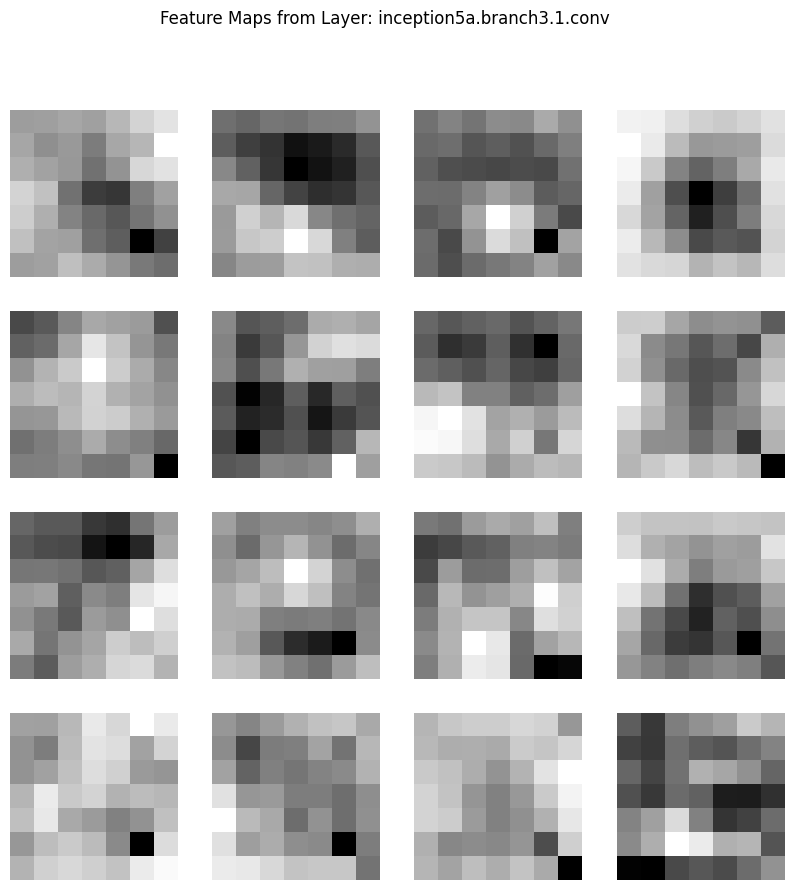

Feature maps for layer: inception5a.branch4.1.conv


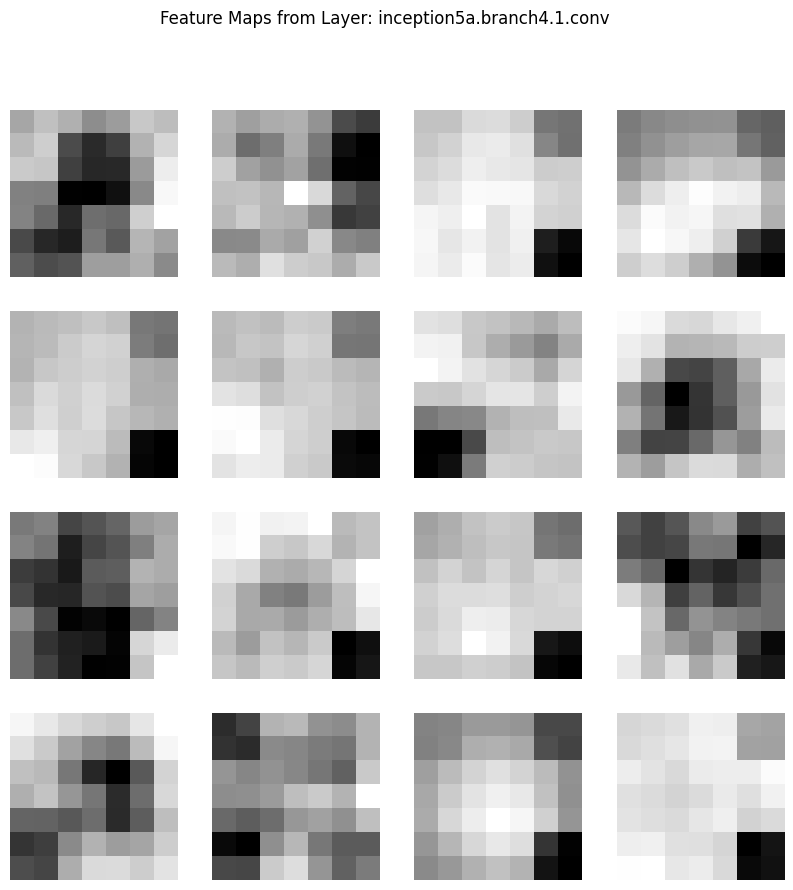

Feature maps for layer: inception5b.branch1.conv


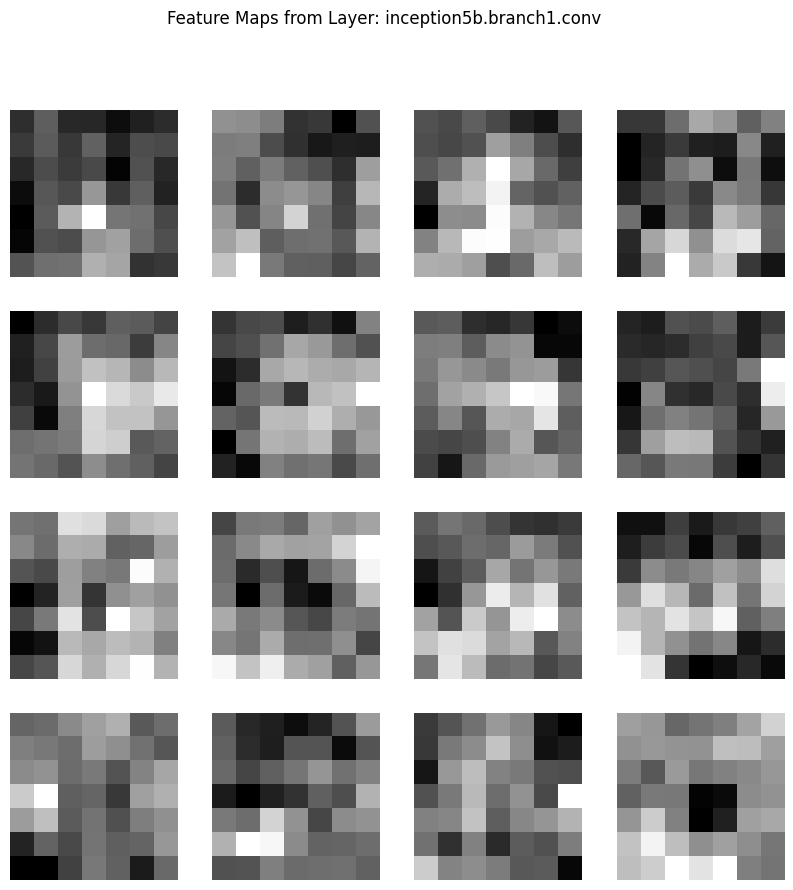

Feature maps for layer: inception5b.branch2.0.conv


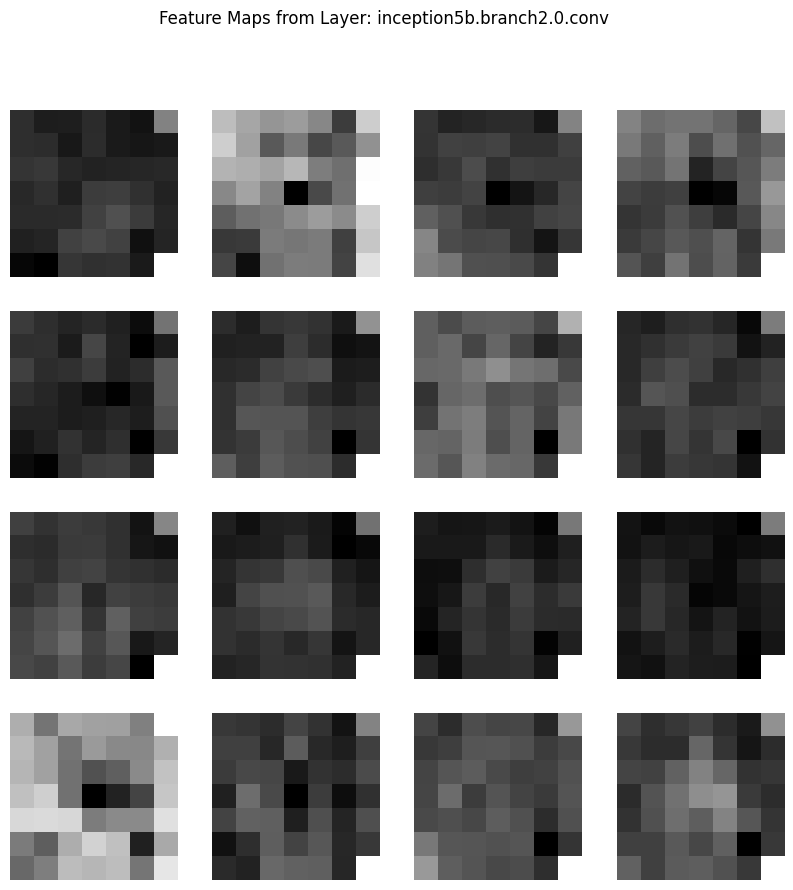

Feature maps for layer: inception5b.branch2.1.conv


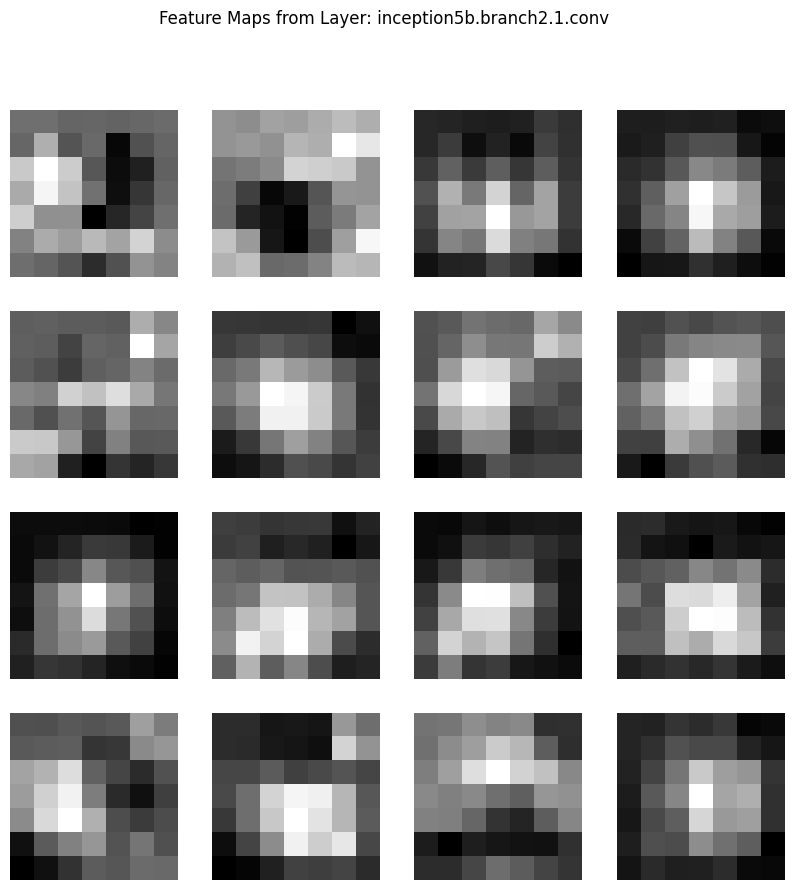

Feature maps for layer: inception5b.branch3.0.conv


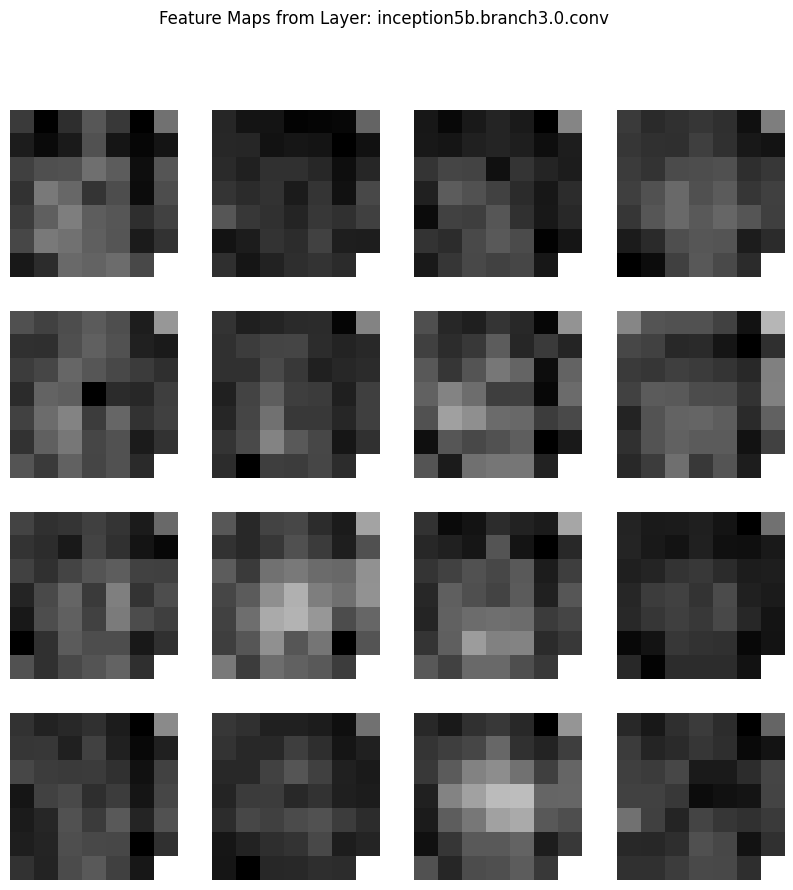

Feature maps for layer: inception5b.branch3.1.conv


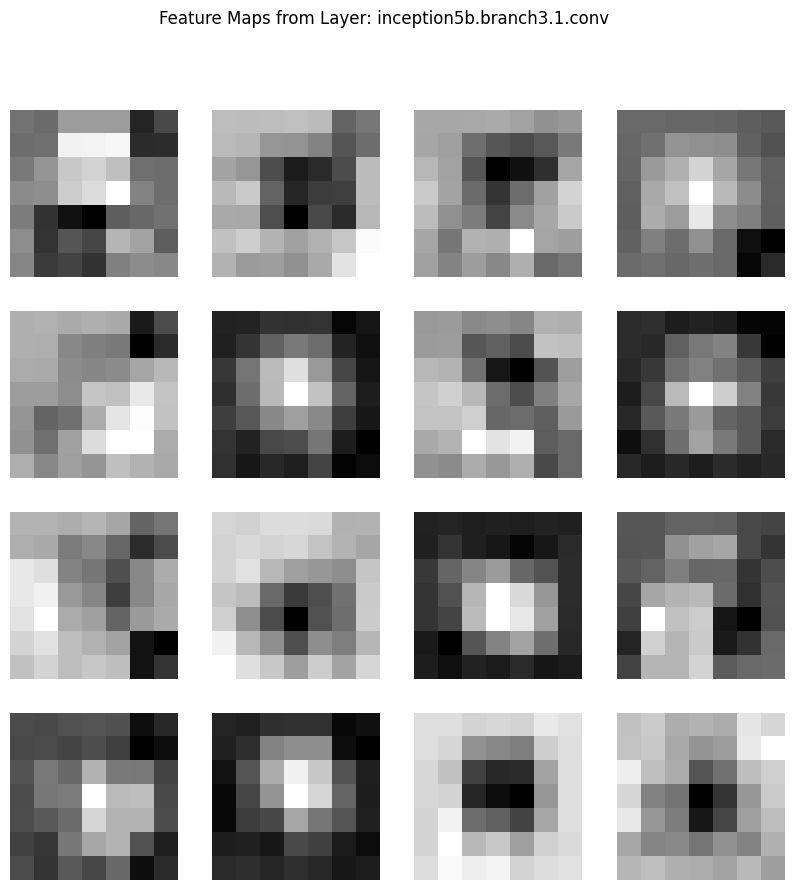

Feature maps for layer: inception5b.branch4.1.conv


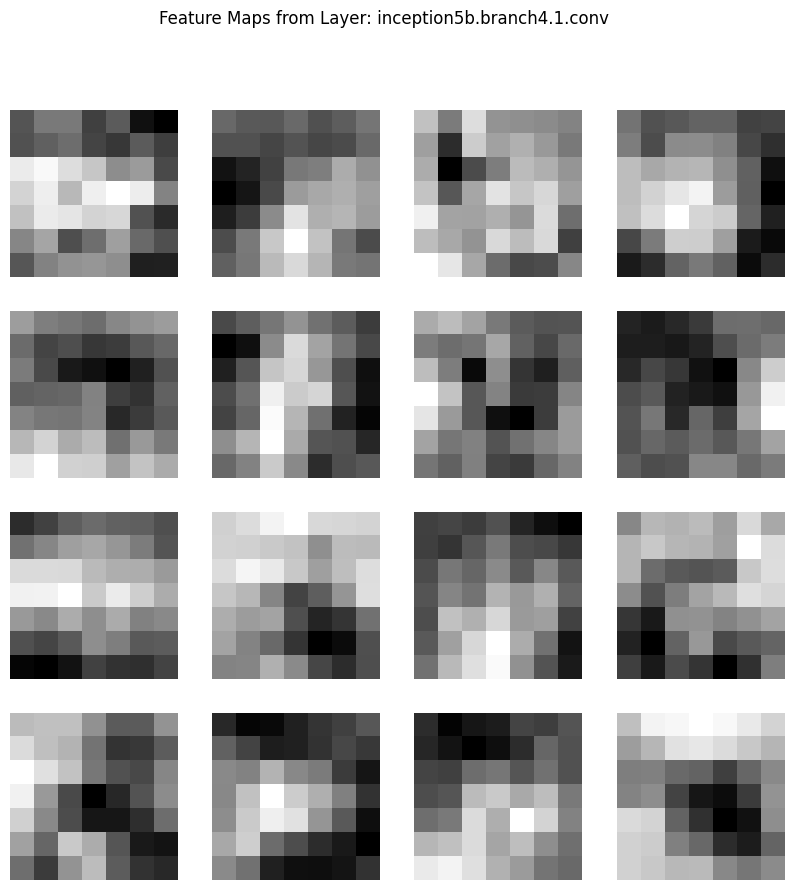

In [12]:
def visualize_feature_maps(model, image):
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()  
        return hook

    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
            layer.register_forward_hook(get_activation(name))

    with torch.no_grad():  
        _ = model(image)

    for name, features in activation.items():
        if isinstance(features, torch.Tensor):
            print(f"Feature maps for layer: {name}")
            feature_num = features.shape[1]

            num_plots = min(feature_num, 16)  
            plt.figure(figsize=(10, 10))  

            for i in range(num_plots):
                plt.subplot(4, 4, i + 1)
                plt.imshow(features[0, i, :, :].cpu().numpy(), cmap='gray')
                plt.axis('off')

            plt.suptitle(f"Feature Maps from Layer: {name}")  
            plt.show()

inp, _ = train_dataset.__getitem__(0)  
inp = inp.unsqueeze(0)  

visualize_feature_maps(googlenet.to(device), inp.to(device)) 